In [4]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import cv2
from tensorflow import keras

### Extracting Masks From RLE
Extract and store Masks for validation set from RLE encoding
(This is necessary for the validation set as we only have run width encoded masks for this dataset)

In [2]:
RLE_encodings_file = "./data/stage1_solution.csv"
data_dir = "./data/stage1_test"

with open(RLE_encodings_file, newline='') as csvfile:
    for i, (imgID, RLE, H, W, _) in enumerate(csv.reader(csvfile, delimiter=',')):
        if i == 0: # Skip row with labels
            continue
        H, W = int(H), int(W)
        img = Image.new(mode='1', size=(W, H))
        pixels = img.load()
        RLE_split = list(map(lambda x: int(x), RLE.split()))
        for RLE_i in range(0, len(RLE_split), 2):
            start, width = RLE_split[RLE_i:RLE_i+2]
            for x in range(start, start + width):
                pixels[(x-1)//H, (x-1)%H] = 1

        # Save Mask
        p = f"{data_dir}/{imgID}/masks"
        if not os.path.exists(p):
            os.mkdir(p)
        img.save(f"{p}/mask_{i}.png")


### Filled holes in the masks

In [7]:
def fill_hole_masks(data_directory):
    for img_dir in os.listdir(data_directory):
        for mask_dir in os.listdir(f"{data_directory}/{img_dir}/masks"):
            # # read the image
            # img_gray = cv2.imread(f"{data_directory}/{img_dir}/masks/{mask_dir}")
            # ret, des = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
            # display(keras.preprocessing.image.array_to_img(des))
            # print(des)
            # contour, hierarchy = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
            
            # for cnt in contour:
            #     cv2.drawContours(des,[cnt],0,255,-1)

            # gray = cv2.bitwise_not(des)

            im_in = cv2.imread(f"{data_directory}/{img_dir}/masks/{mask_dir}", cv2.IMREAD_GRAYSCALE)
 
            # Threshold.
            # Set values equal to or above 220 to 0.
            # Set values below 220 to 255.
            th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV)
            im_th = cv2.bitwise_not(im_th)
            # Copy the thresholded image.
            im_floodfill = im_th.copy()
            
            # Mask used to flood filling.
            # Notice the size needs to be 2 pixels than the image.
            h, w = im_th.shape[:2]
            mask = np.zeros((h+2, w+2), np.uint8)
            
            # Floodfill from point (0, 0)
            cv2.floodFill(im_floodfill, mask, (0,0), 255)
            
            # Invert floodfilled image
            im_floodfill_inv = cv2.bitwise_not(im_floodfill)
            
            # Combine the two images to get the foreground.
            im_out = im_th | im_floodfill_inv
            if (np.count_nonzero(im_in == 255) == 0 and np.count_nonzero(im_out == 255) != 0) or np.count_nonzero(im_out == 255)*1.2 < np.count_nonzero(im_in == 255) or np.count_nonzero(im_out == 255) > np.count_nonzero(im_in == 255) * 1.2:
                im_out = im_in
            p = f"{data_directory}/{img_dir}/masks_filled"
            if not (im_out == im_in).all():
                plt.imshow(im_in)
                plt.show()
                plt.imshow(im_out)
                plt.show()
            
            if not os.path.exists(p):
                os.mkdir(p)
            cv2.imwrite(f"{p}/{mask_dir}", im_out)

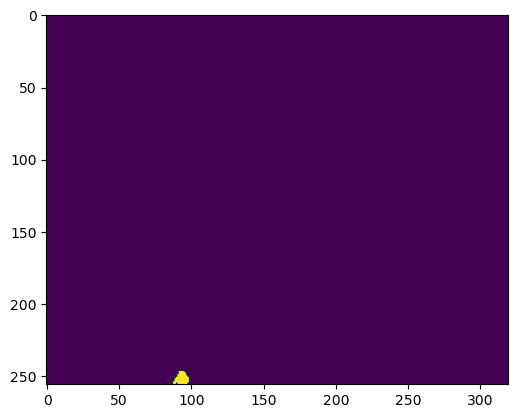

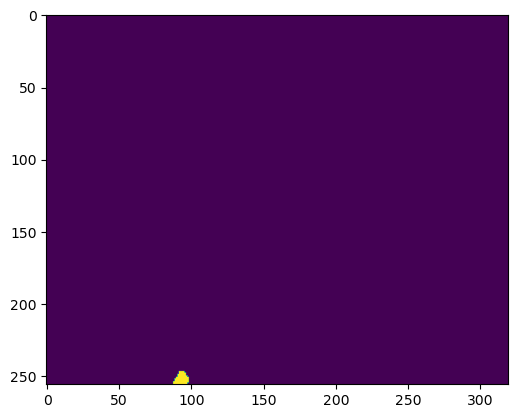

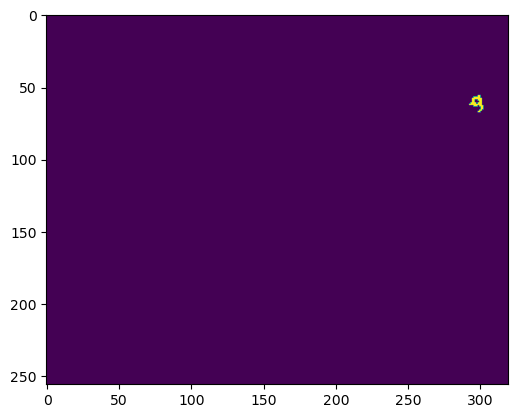

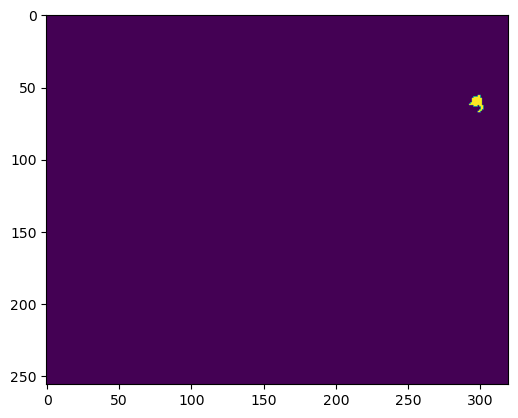

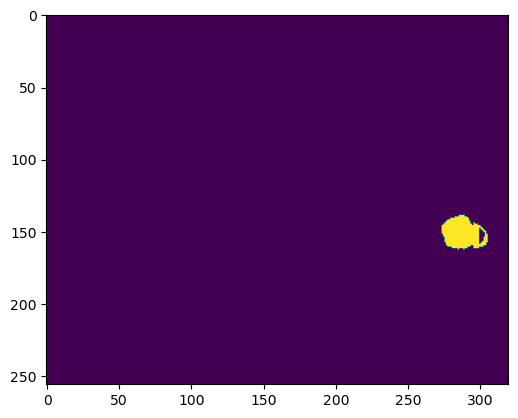

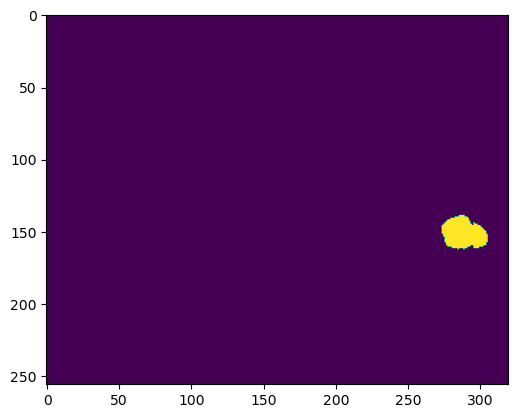

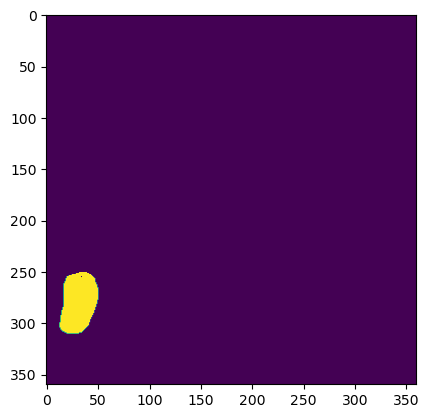

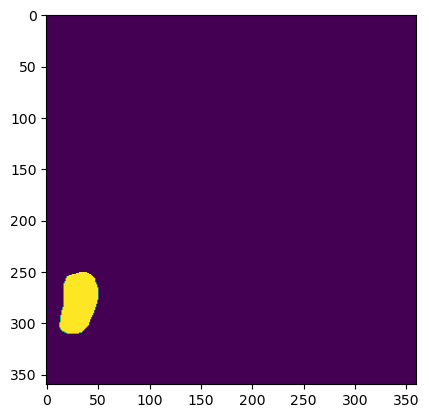

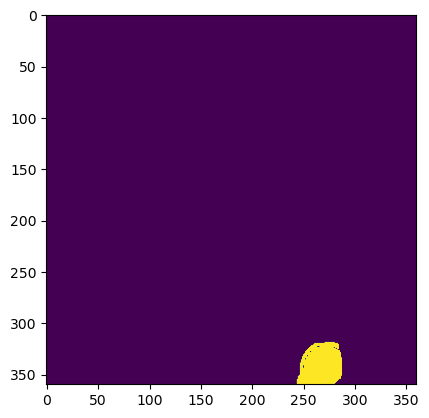

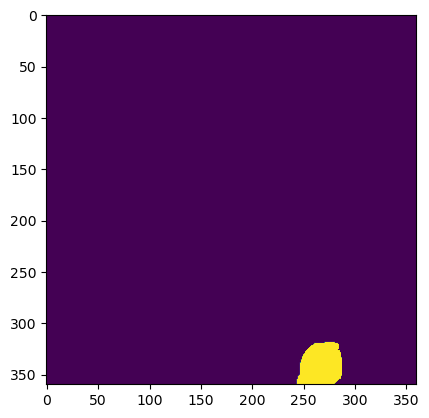

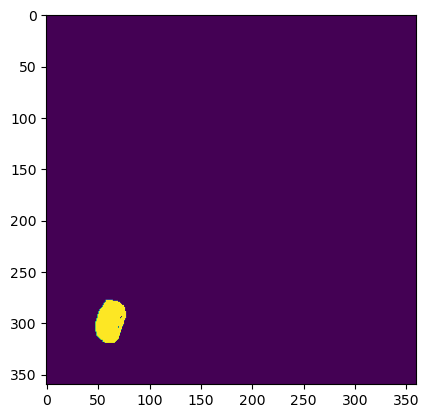

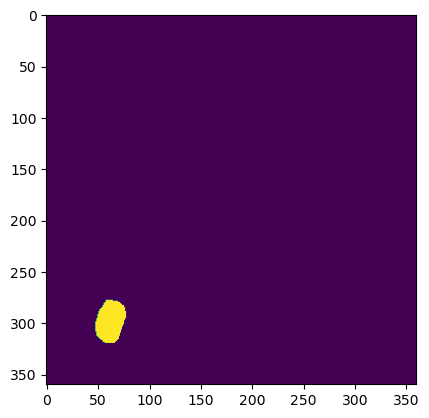

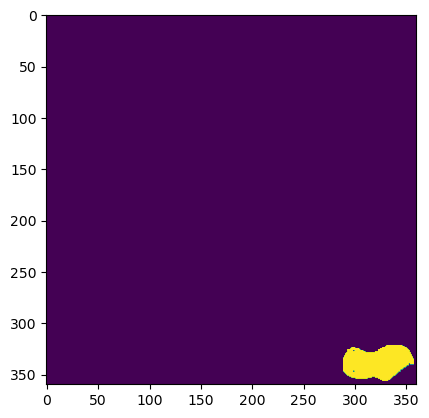

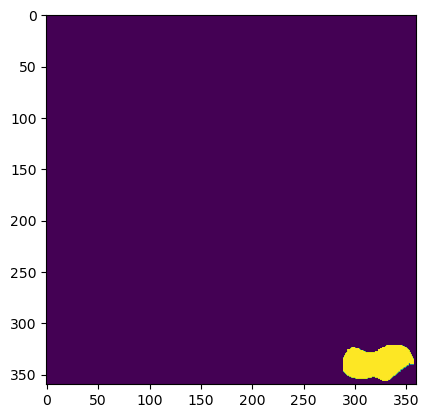

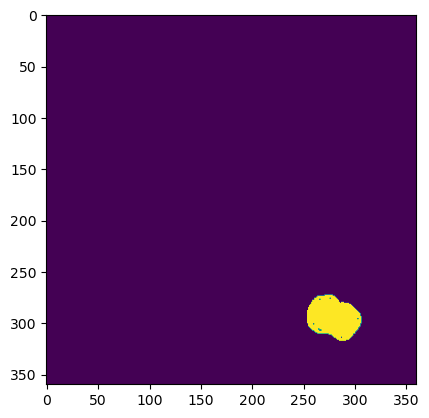

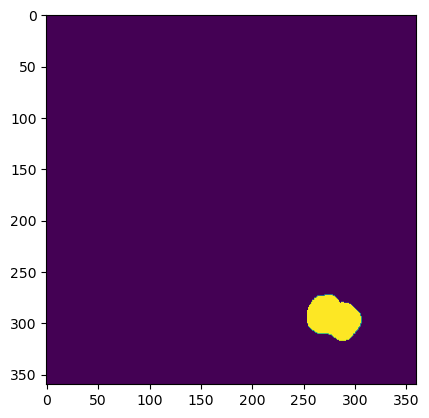

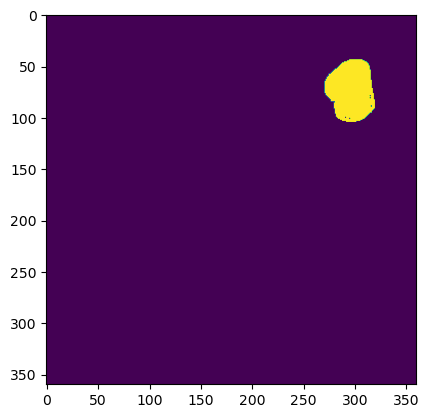

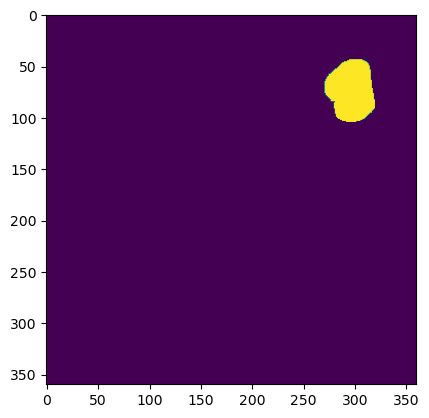

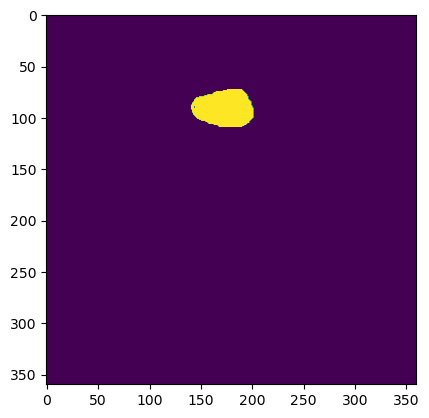

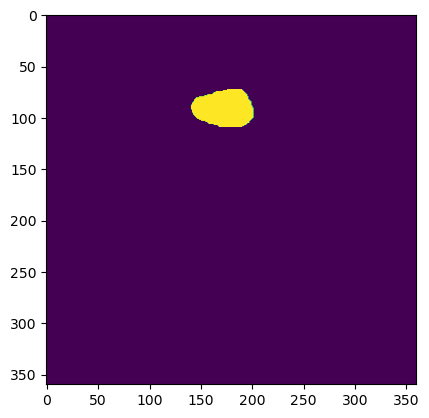

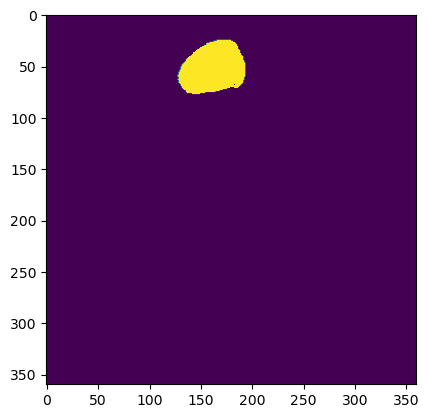

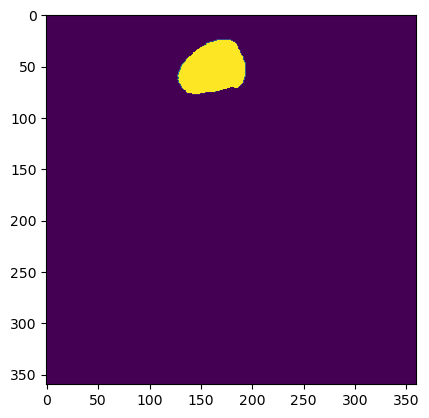

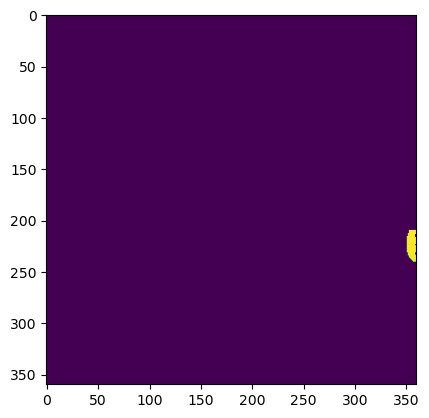

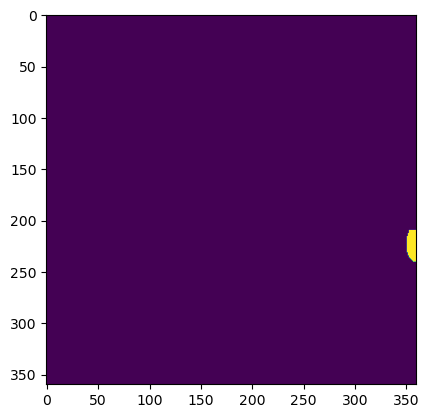

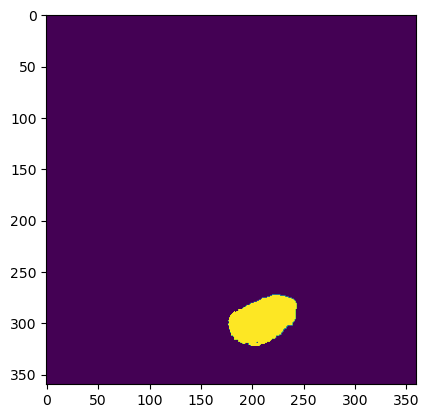

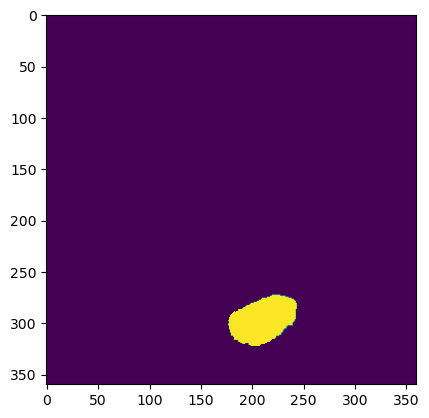

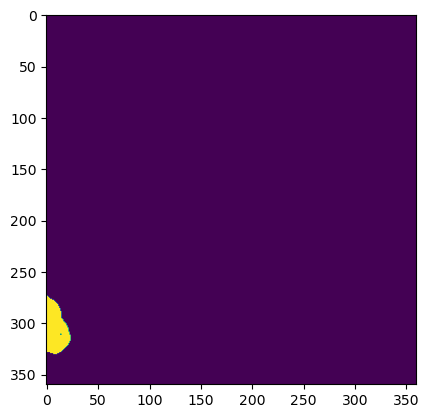

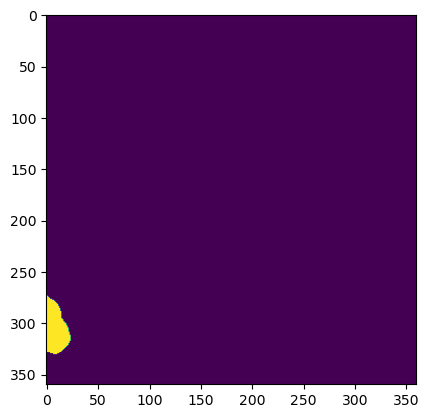

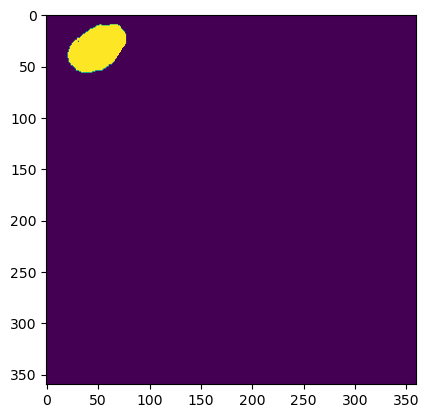

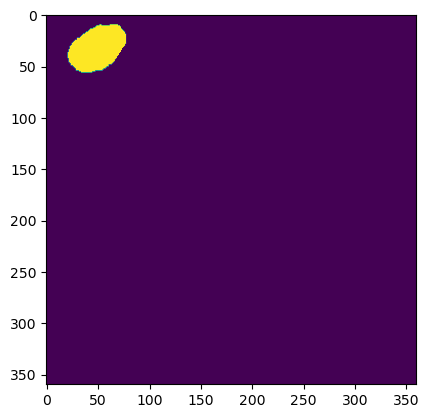

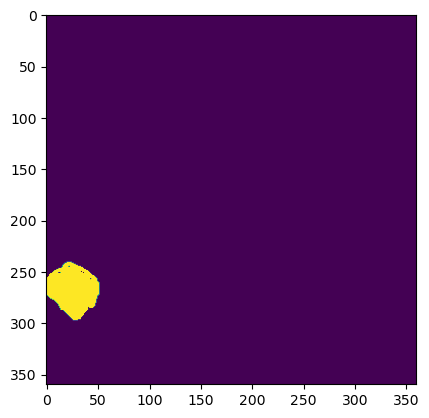

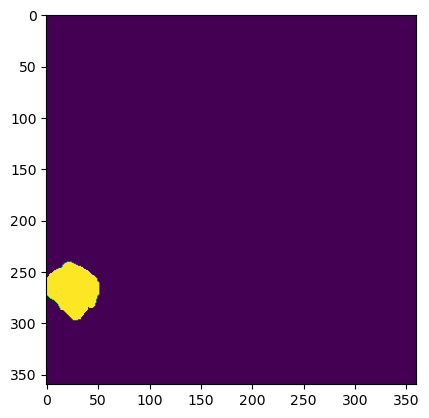

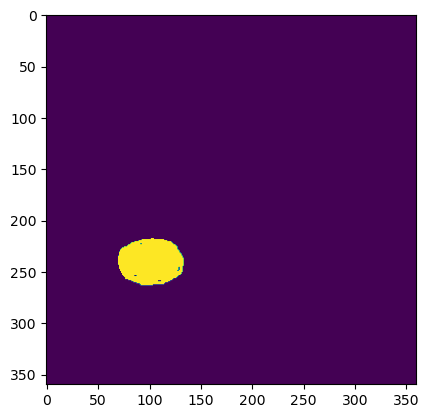

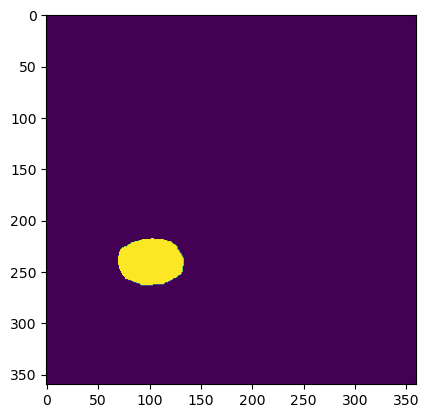

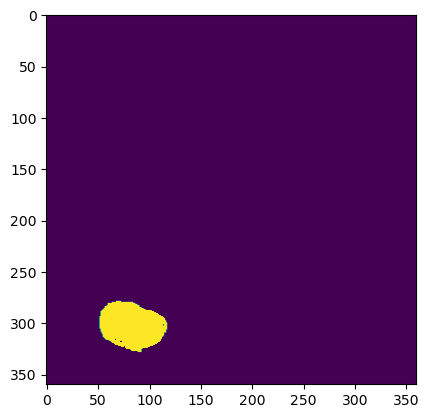

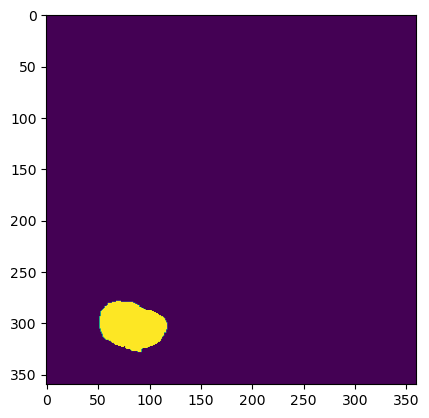

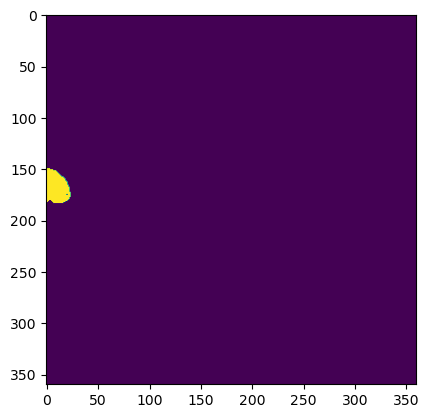

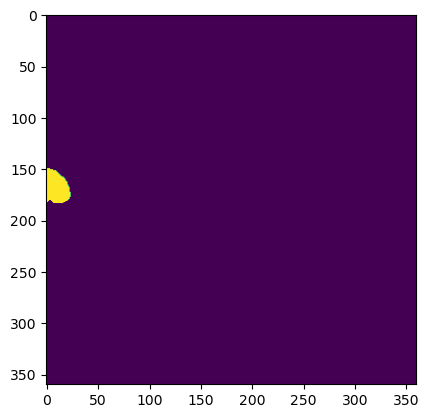

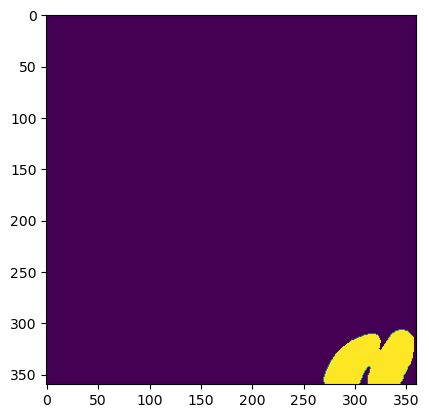

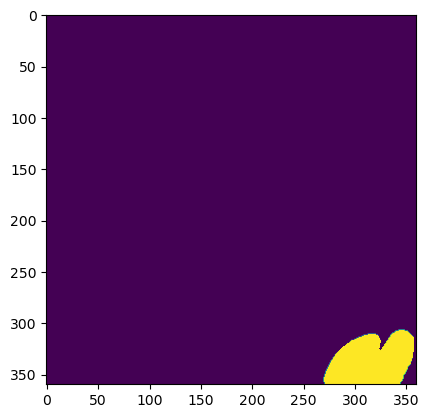

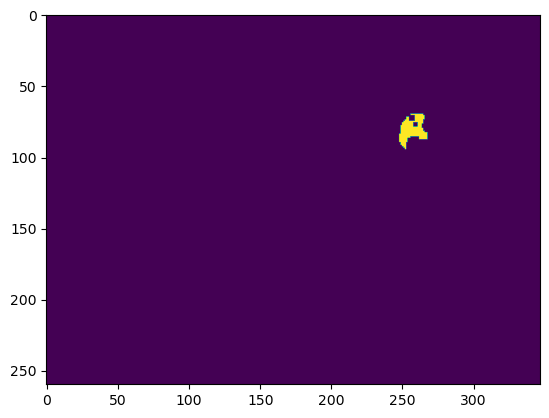

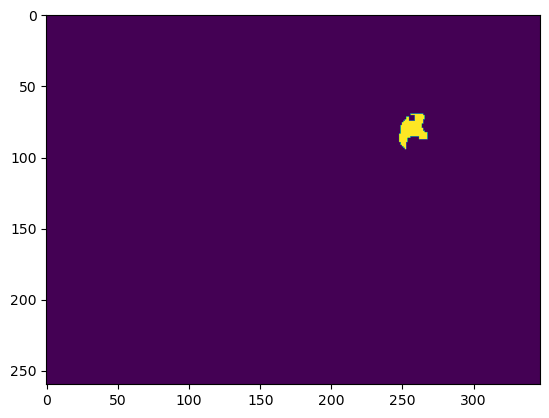

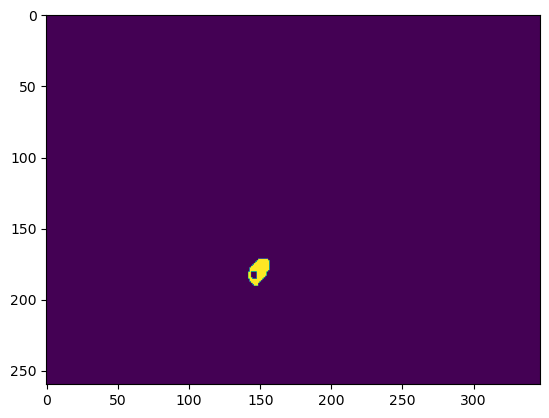

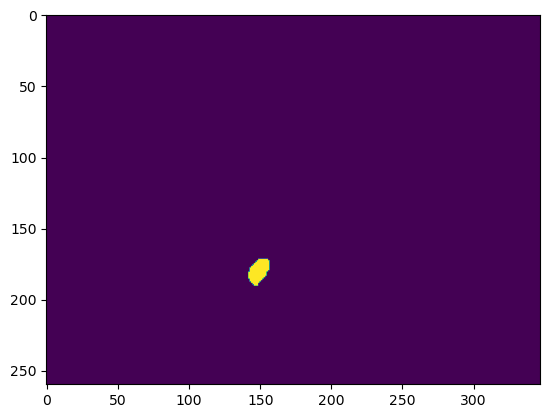

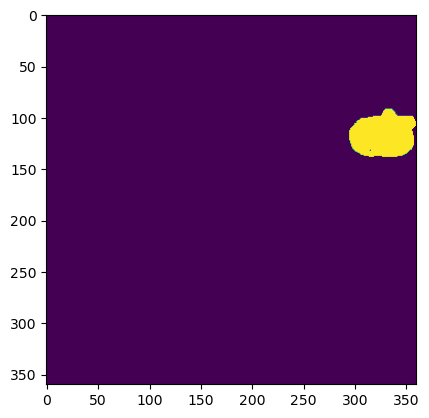

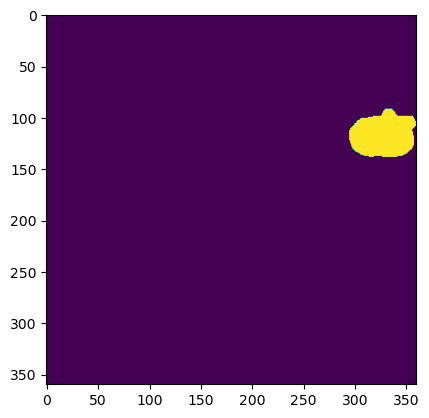

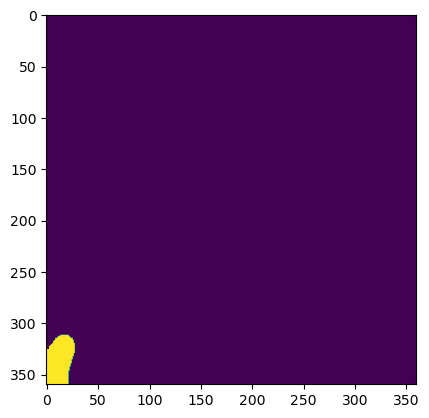

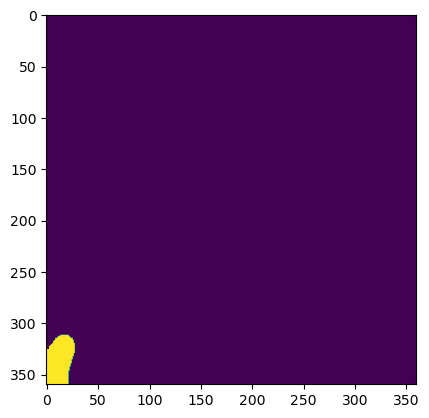

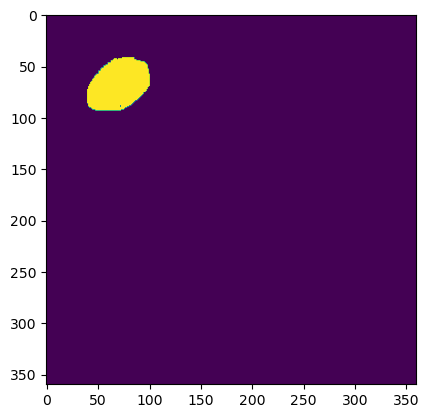

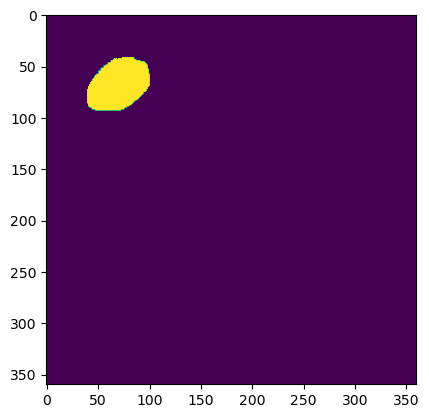

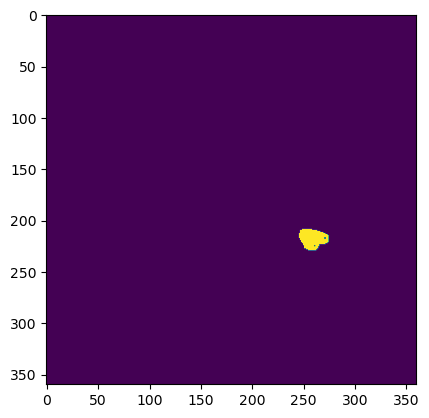

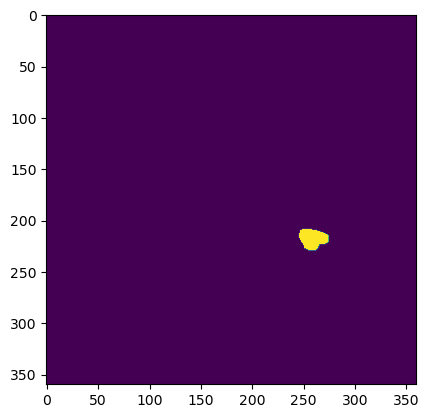

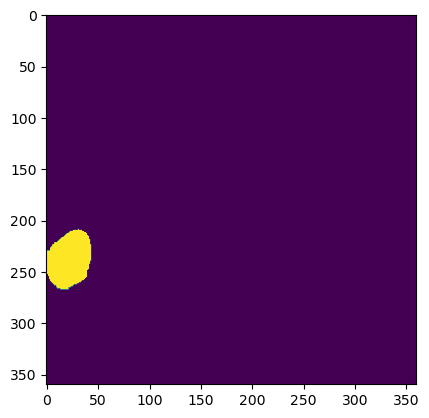

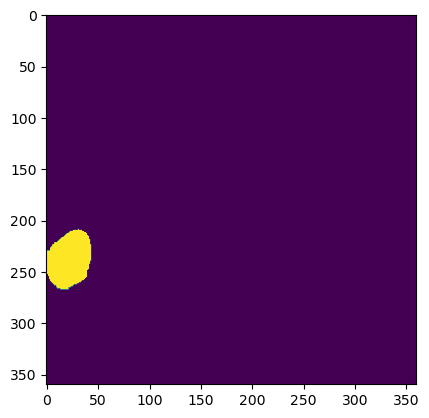

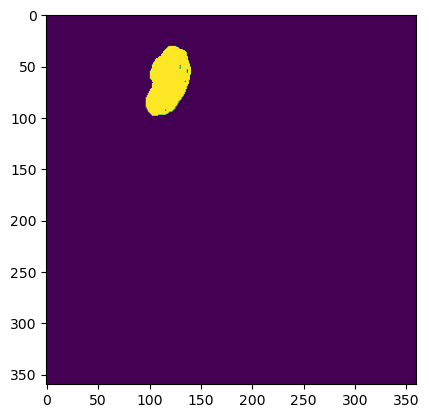

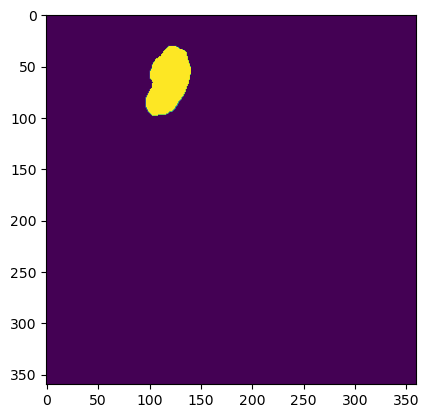

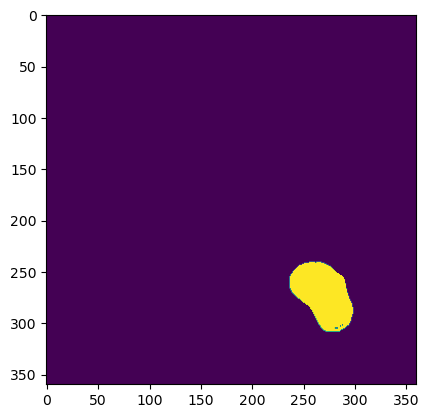

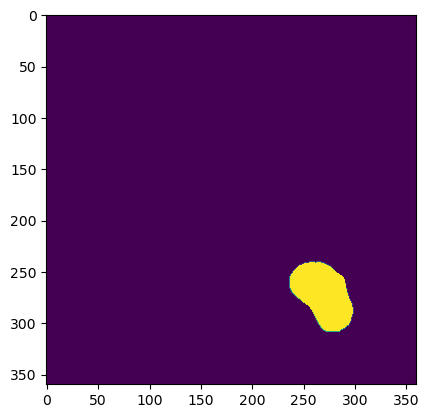

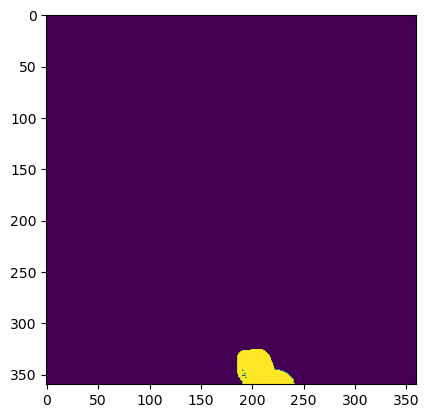

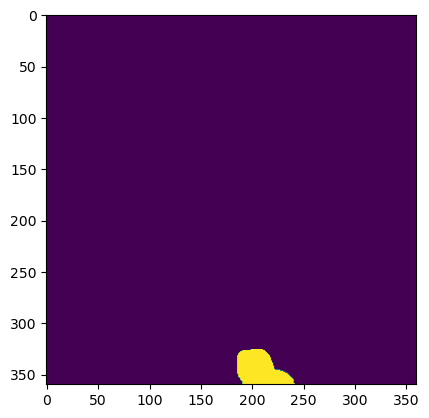

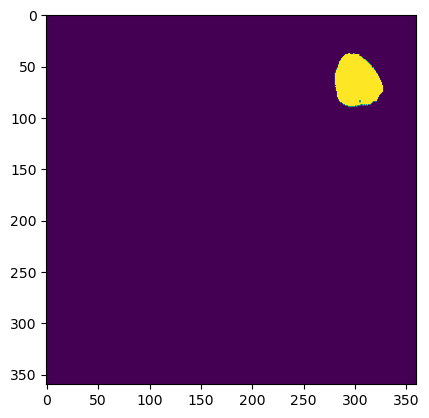

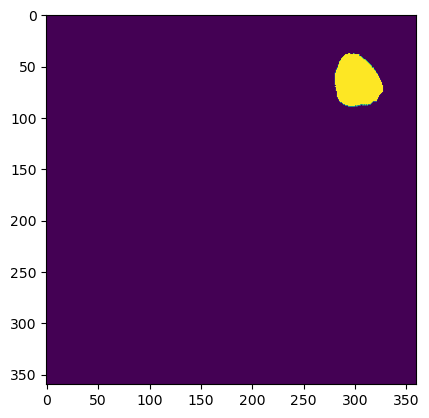

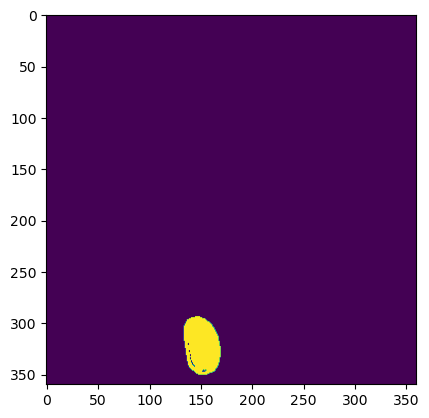

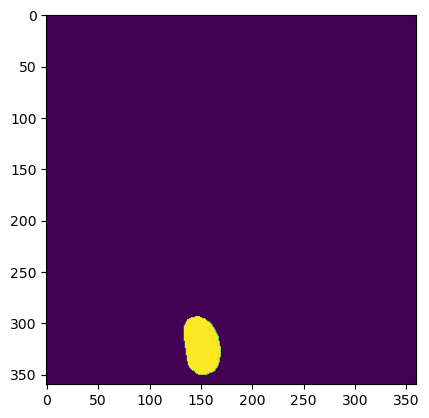

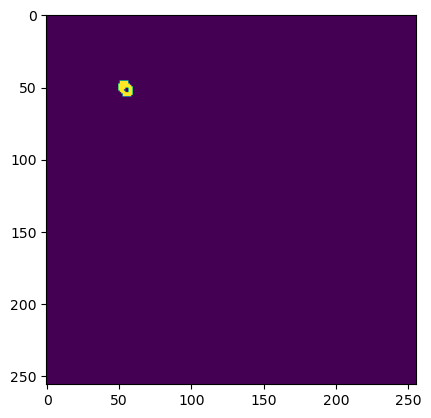

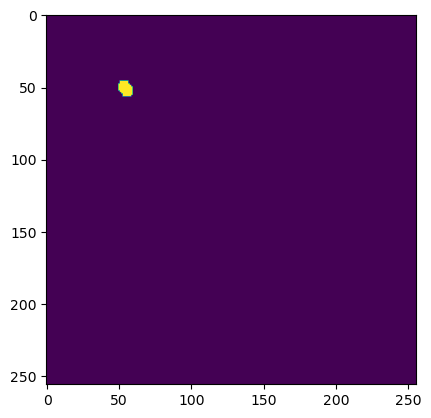

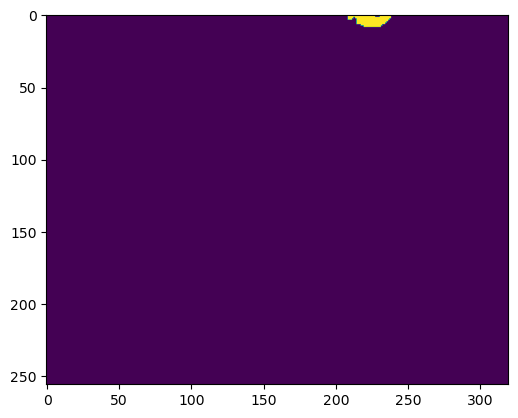

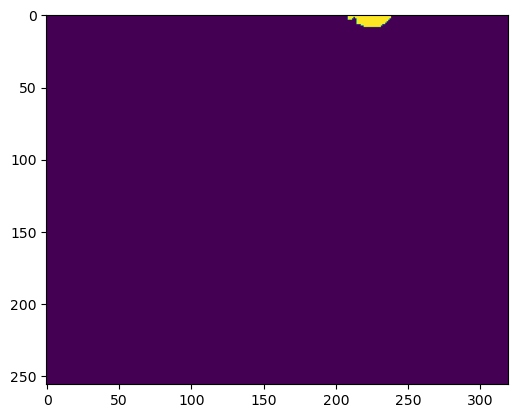

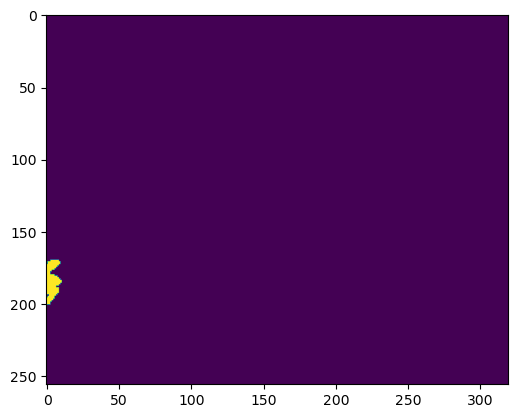

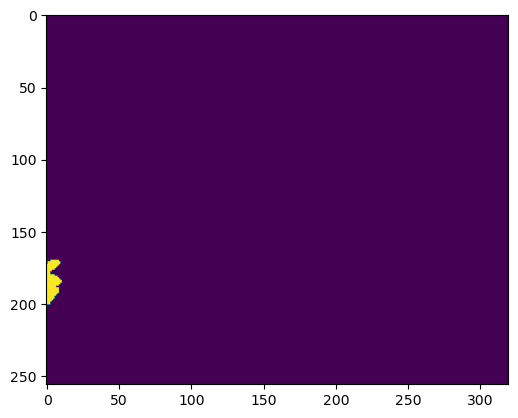

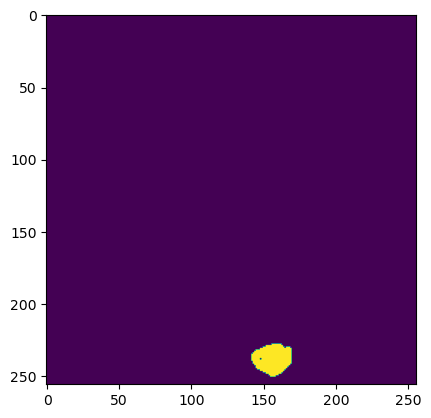

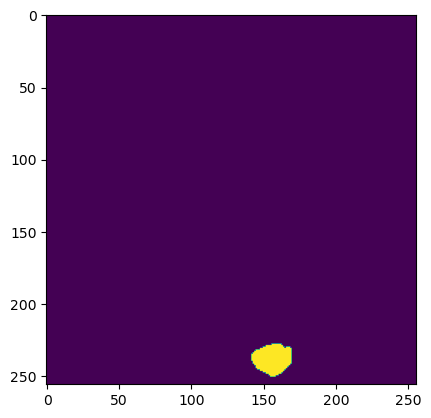

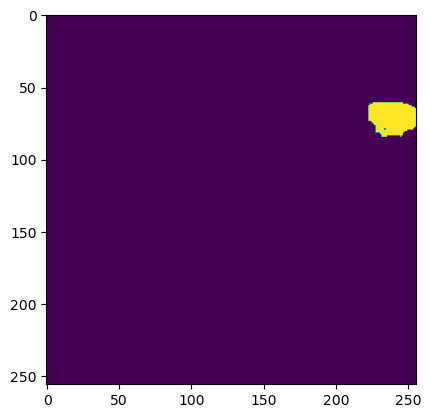

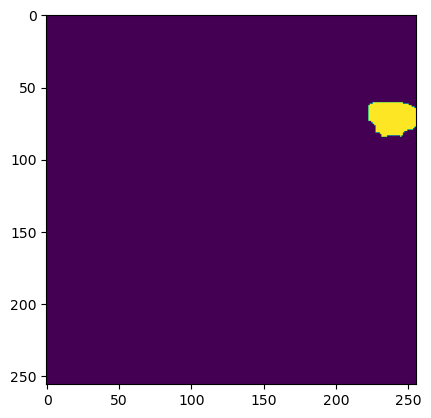

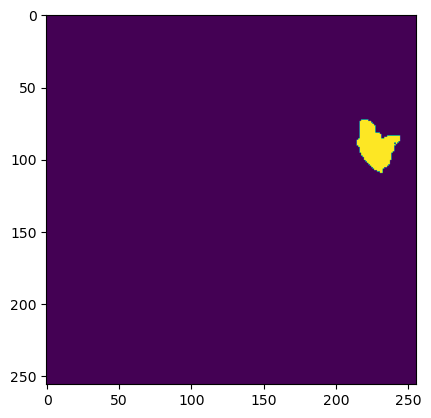

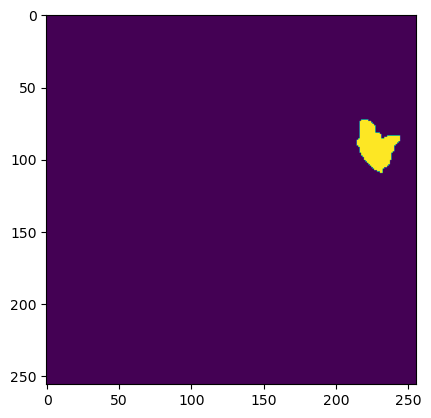

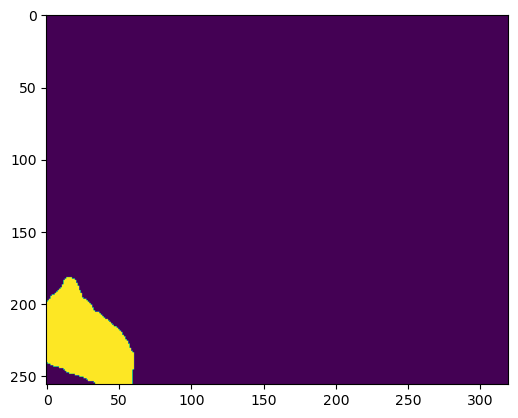

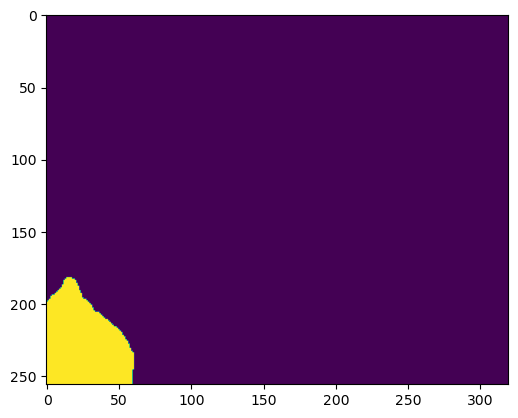

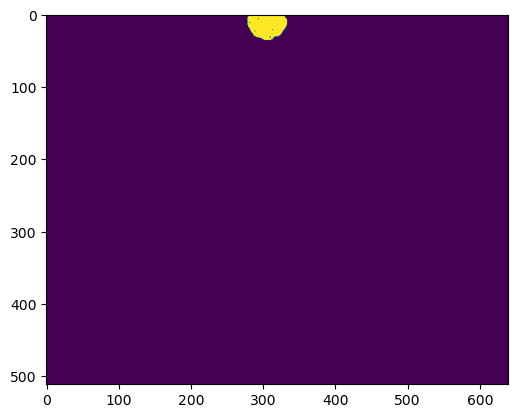

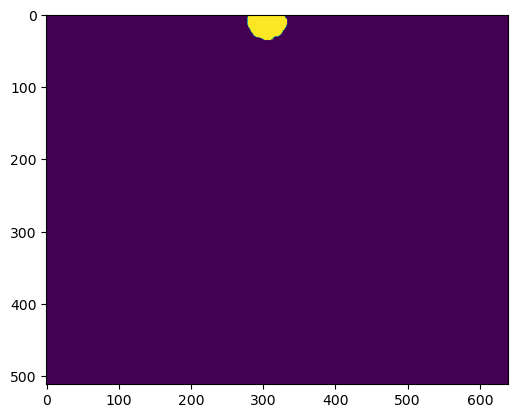

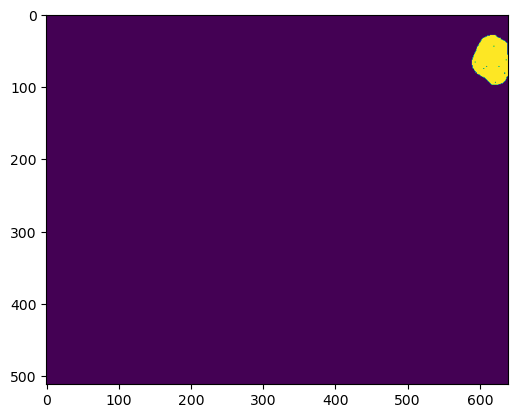

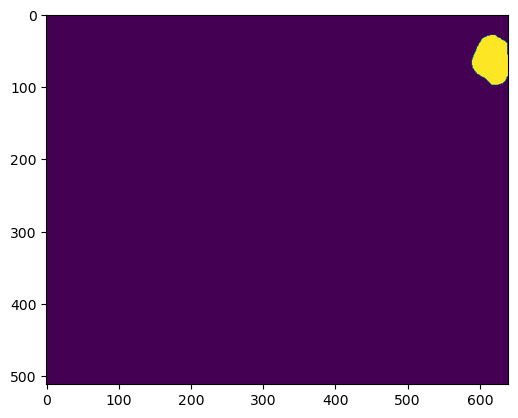

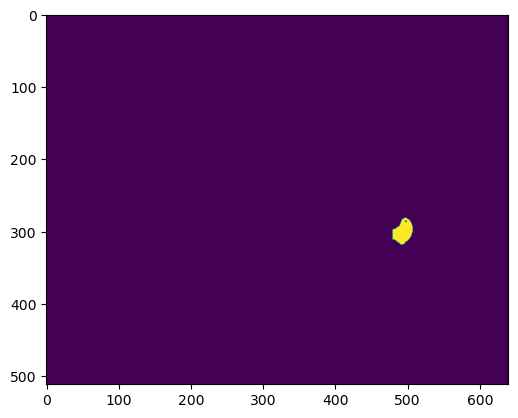

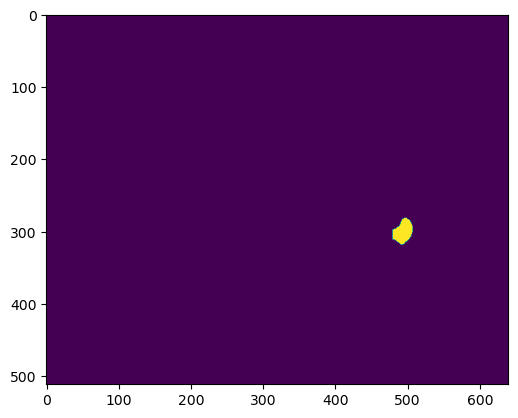

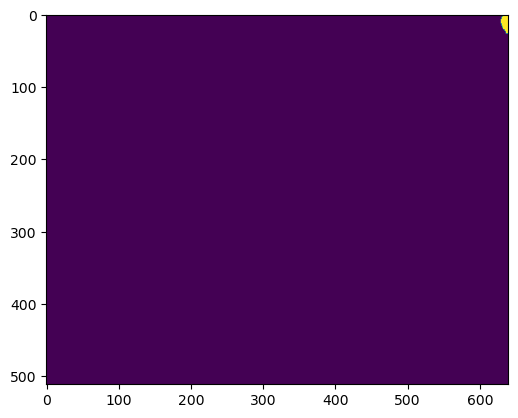

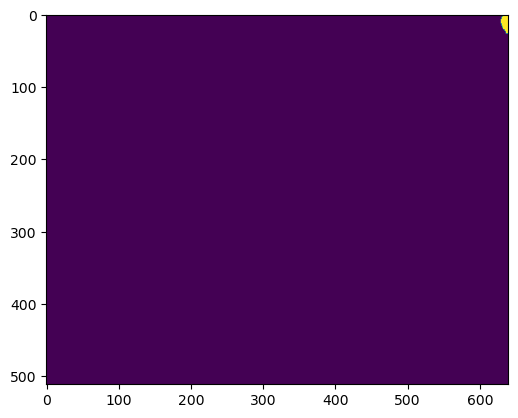

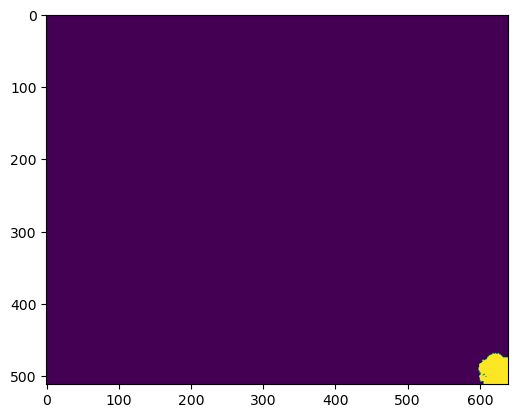

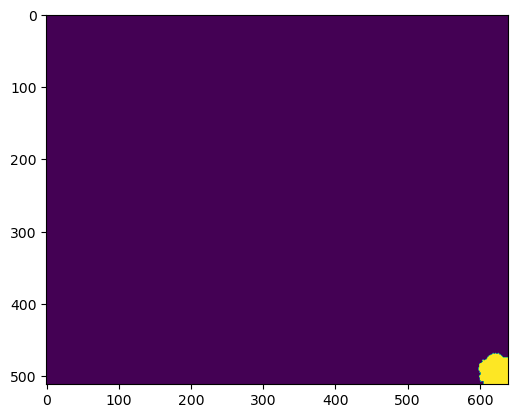

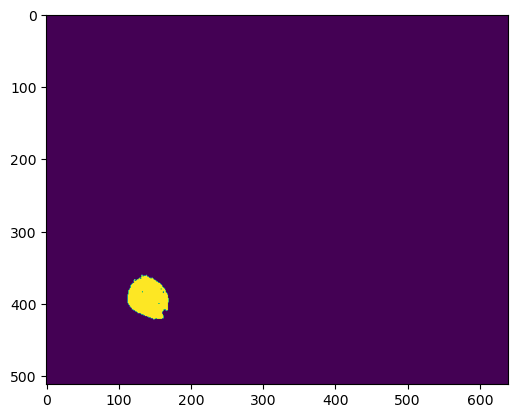

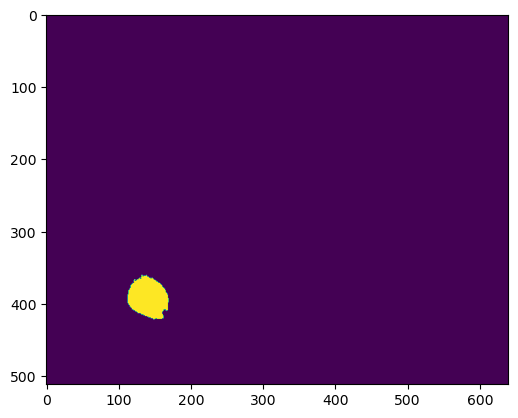

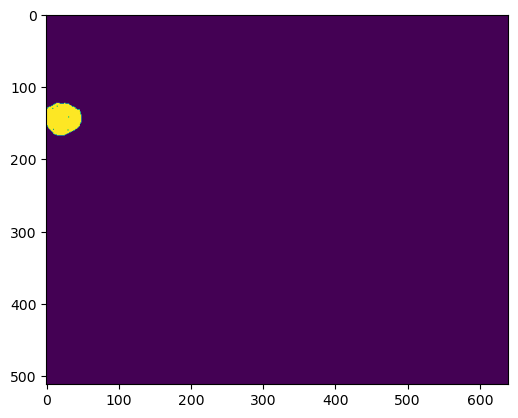

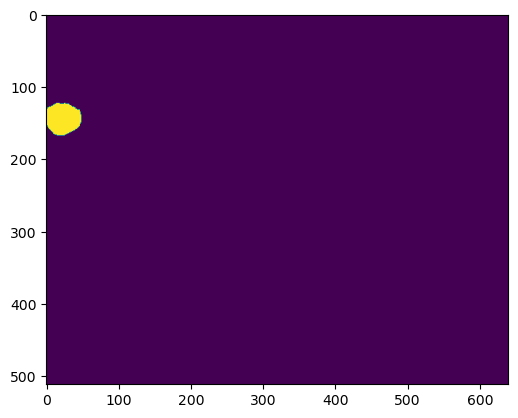

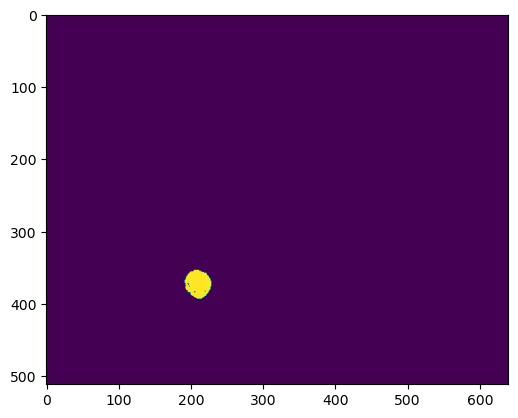

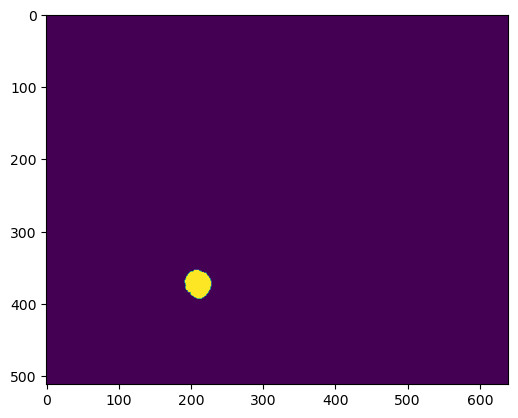

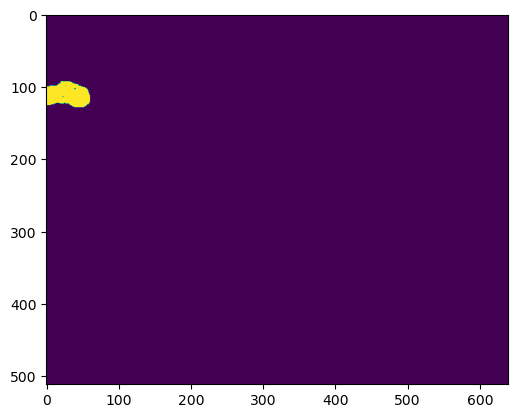

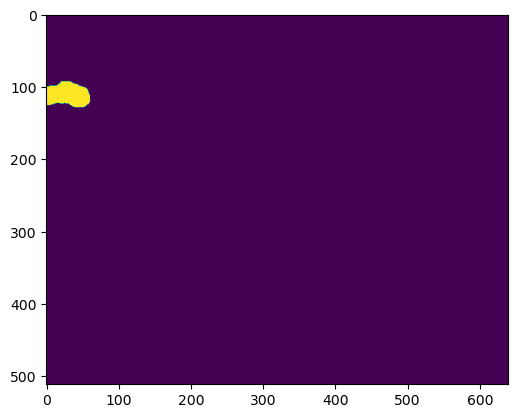

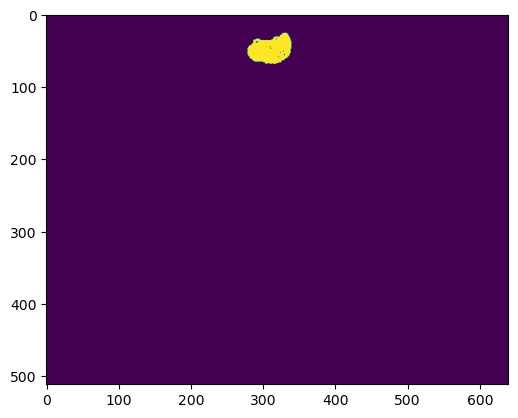

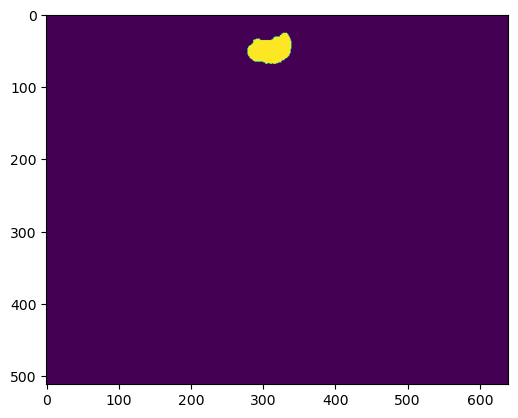

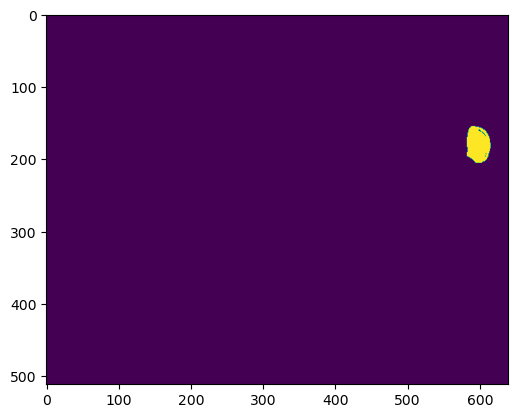

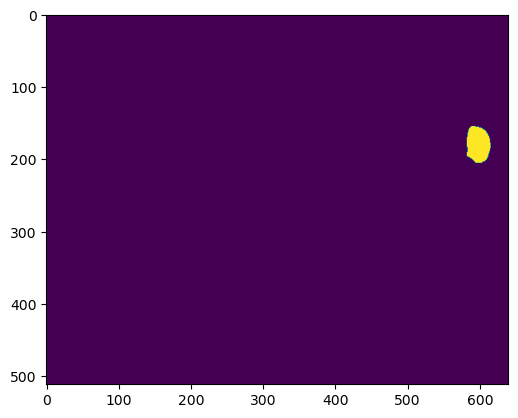

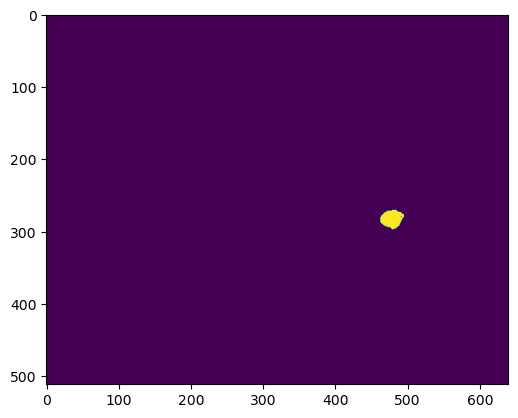

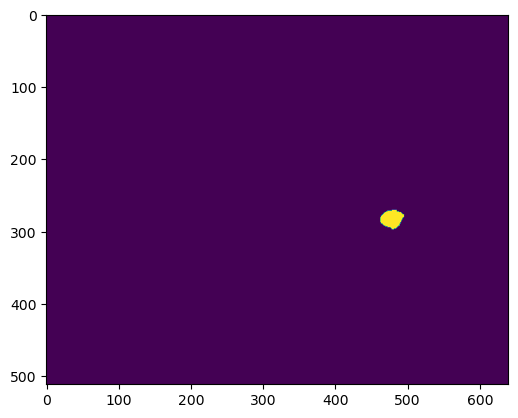

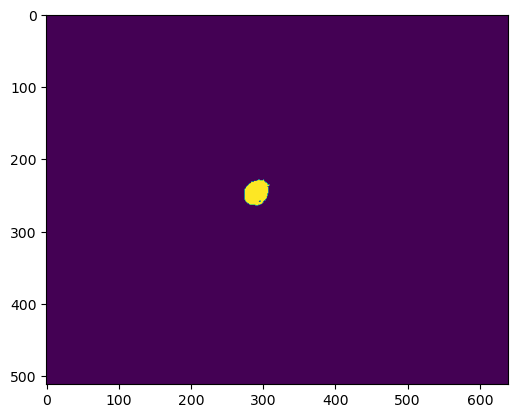

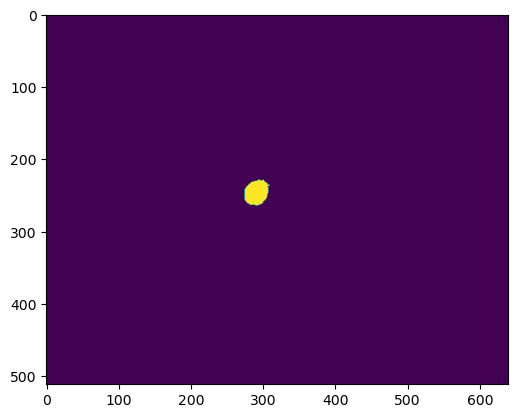

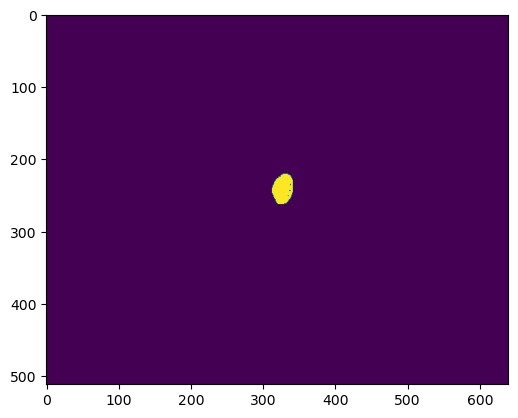

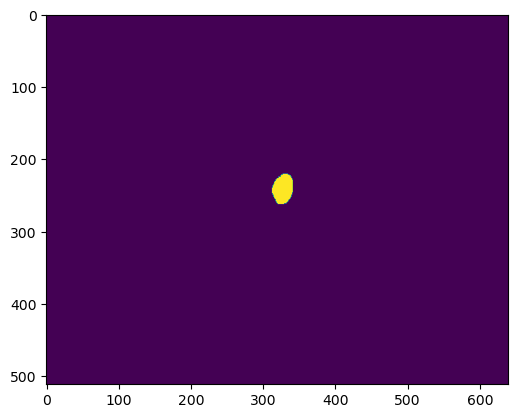

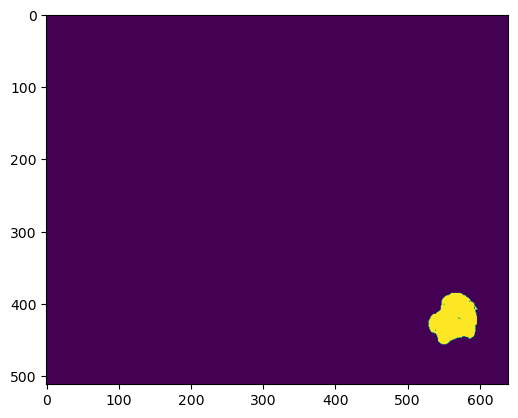

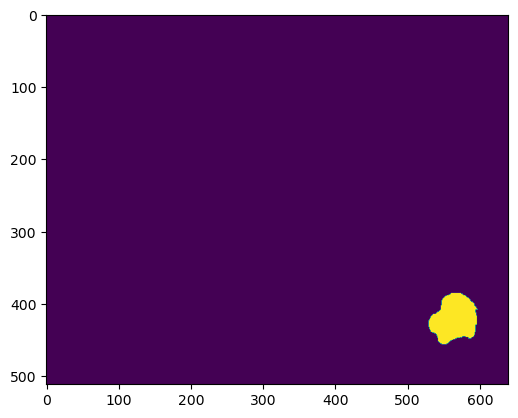

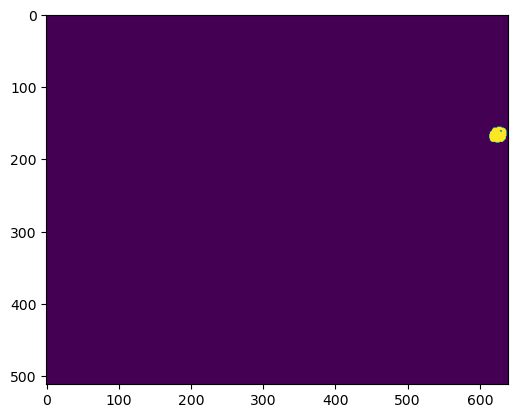

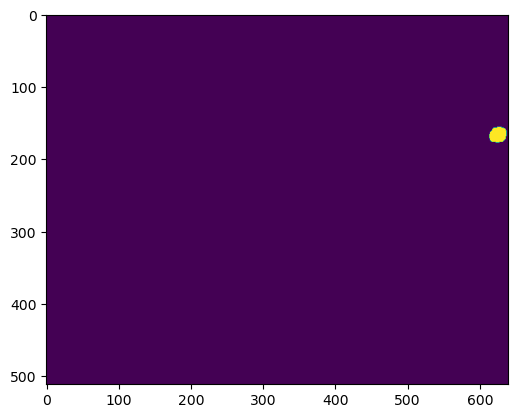

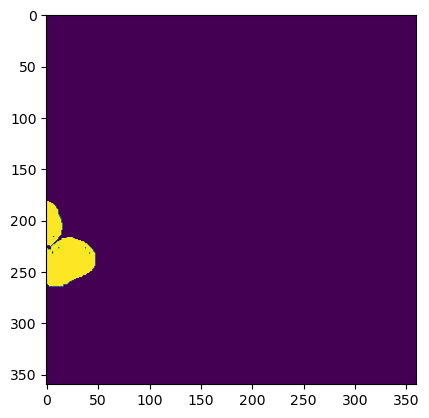

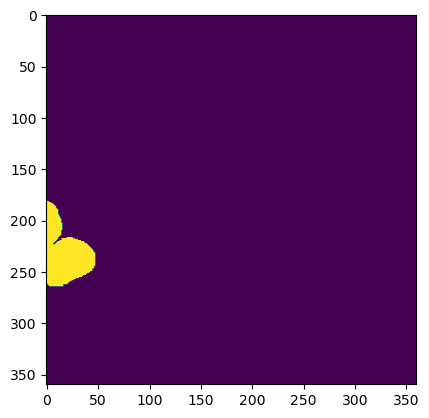

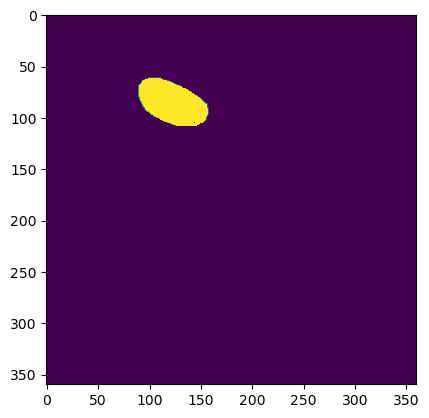

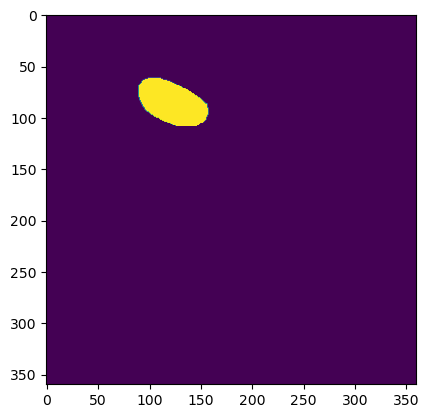

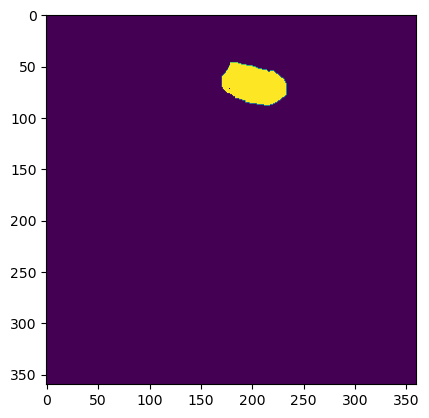

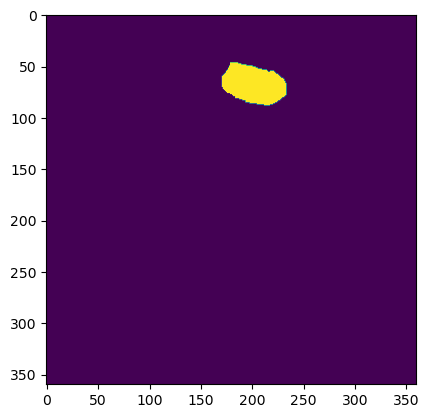

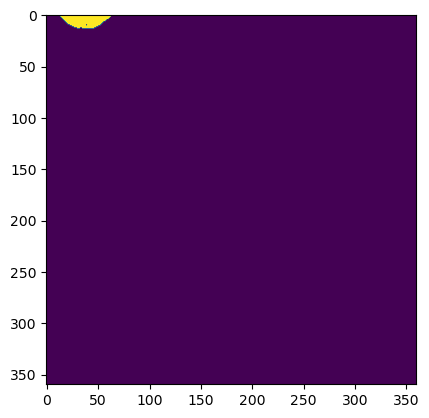

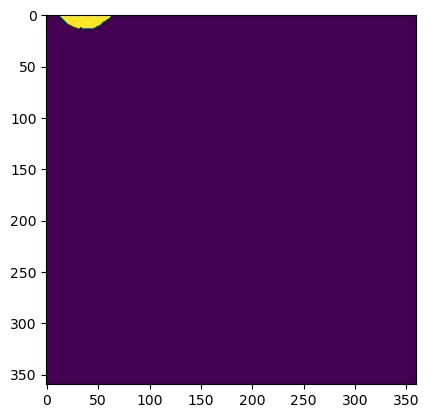

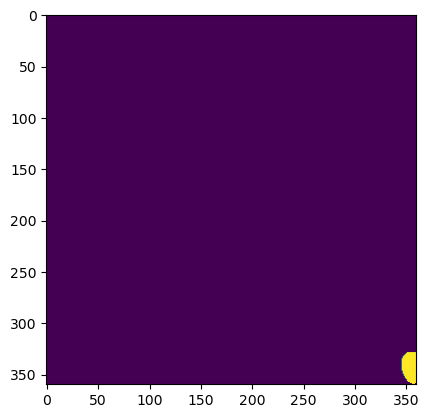

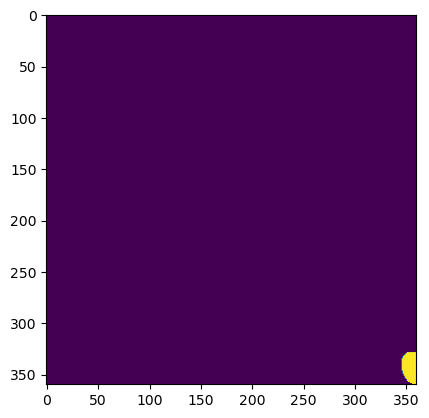

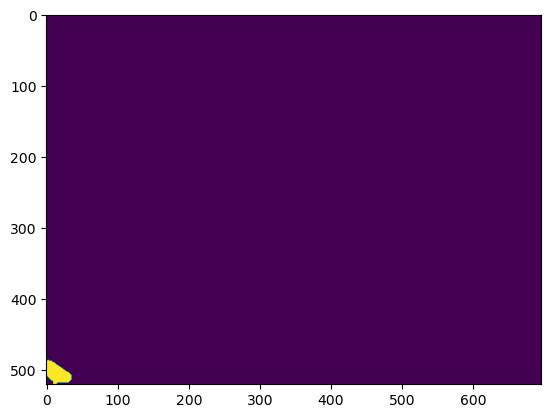

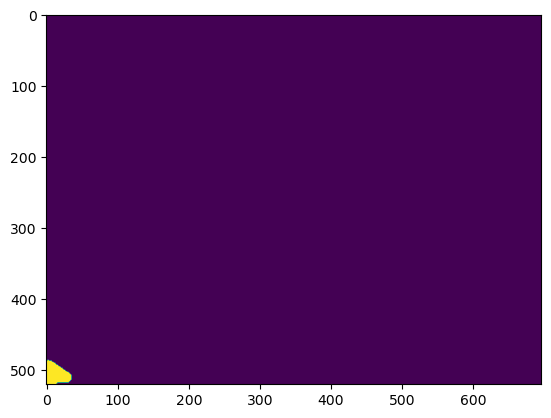

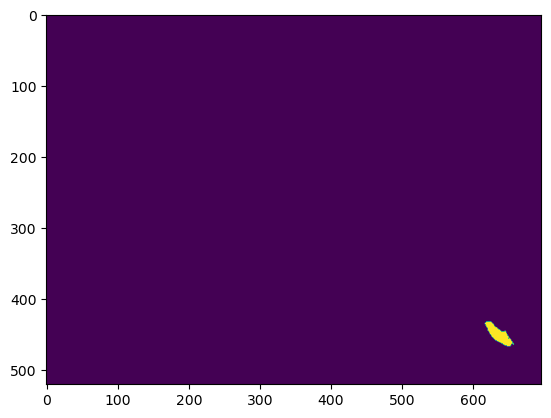

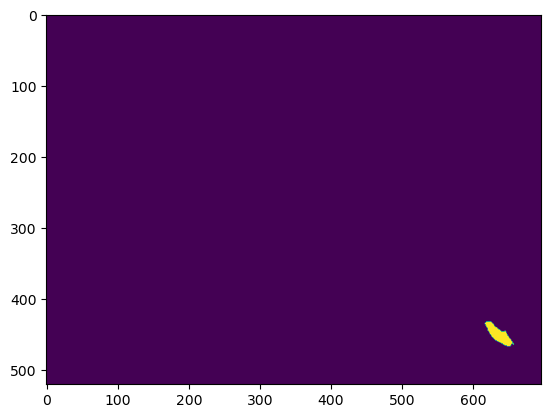

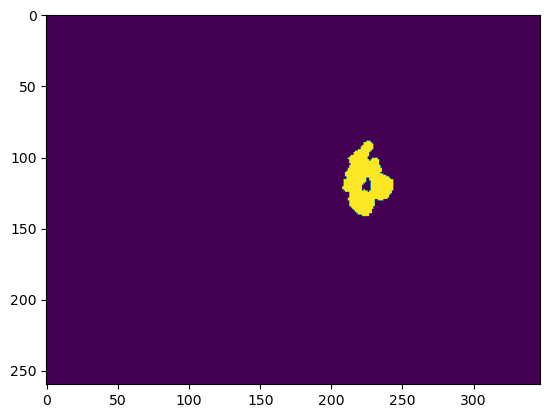

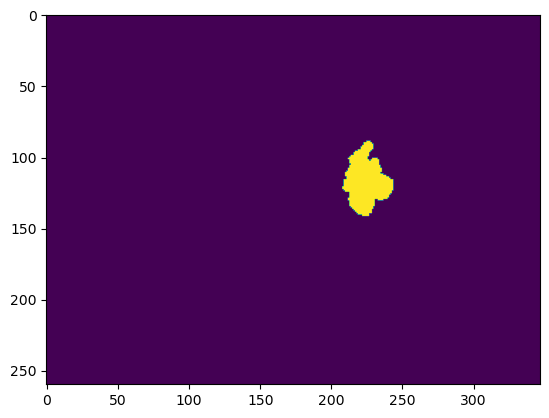

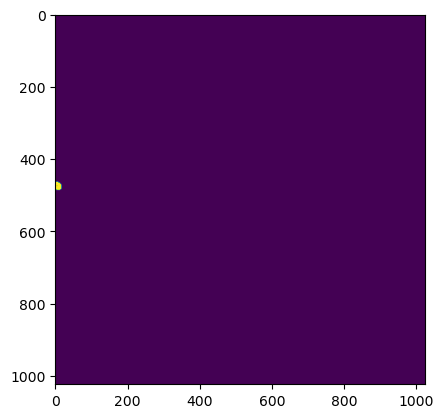

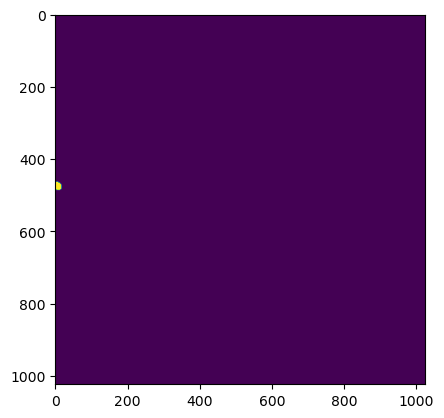

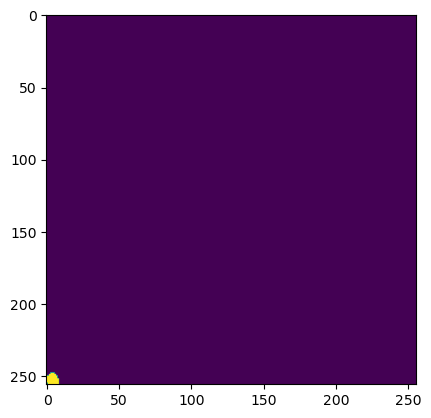

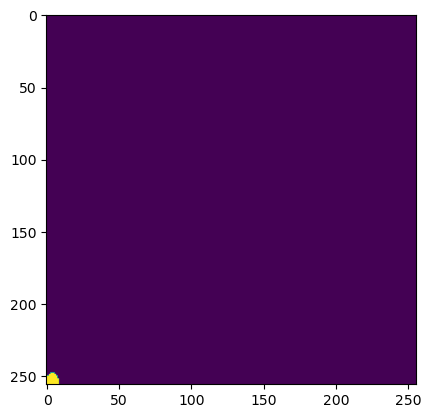

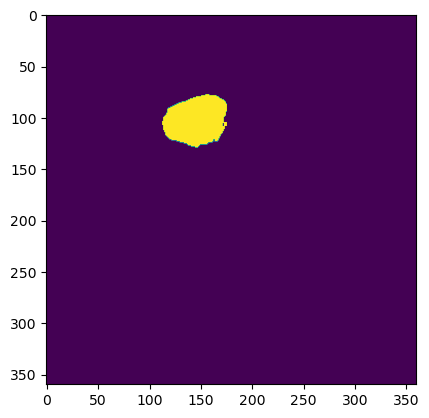

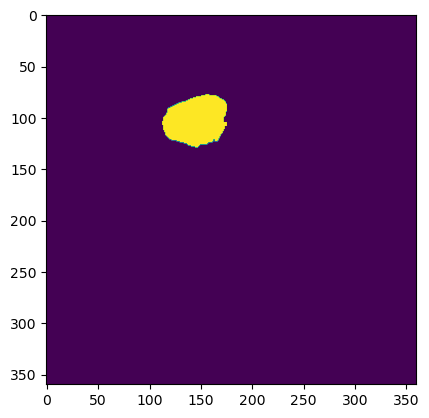

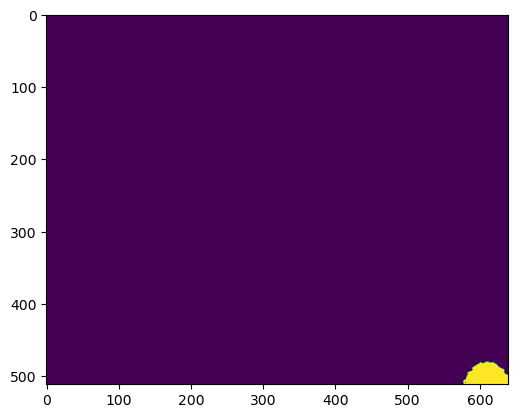

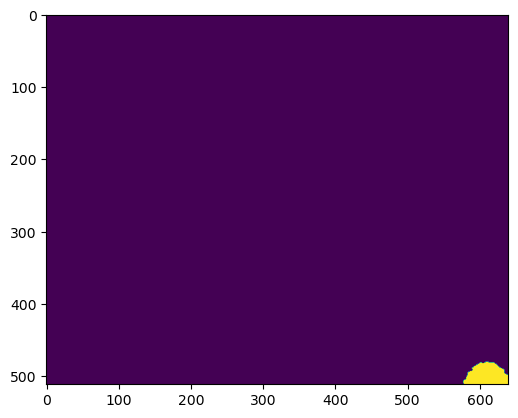

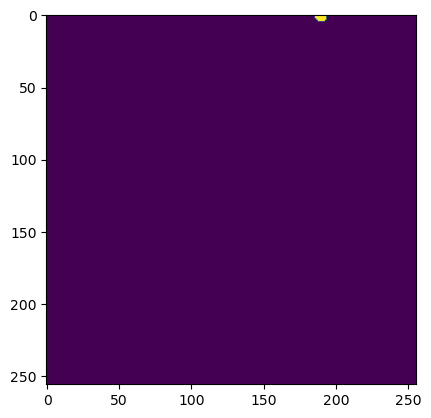

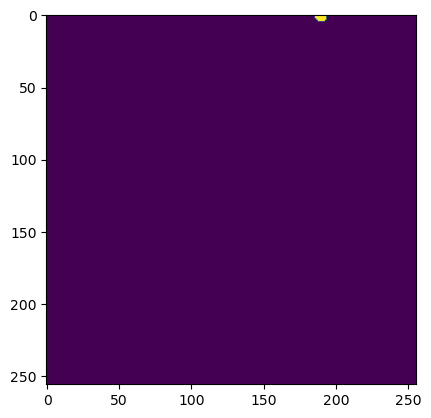

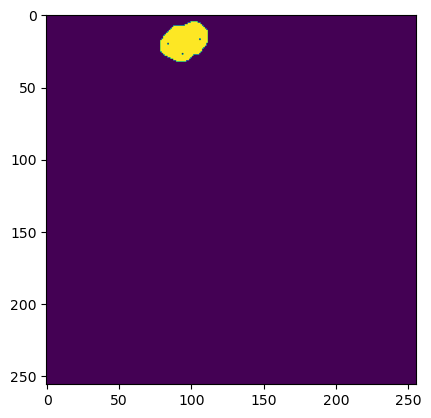

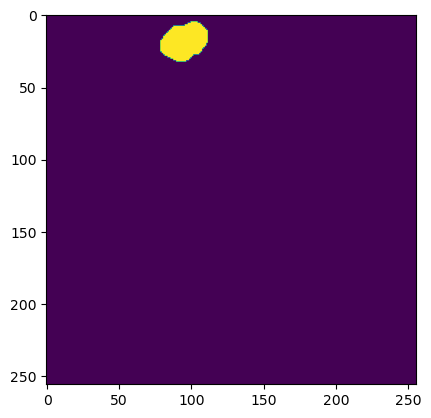

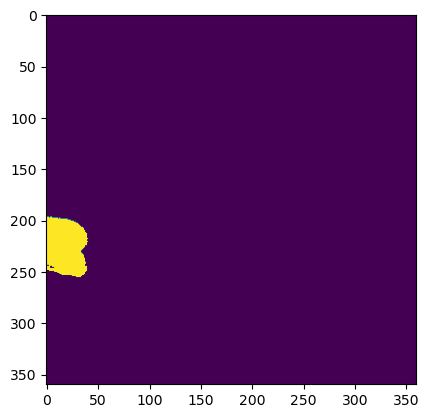

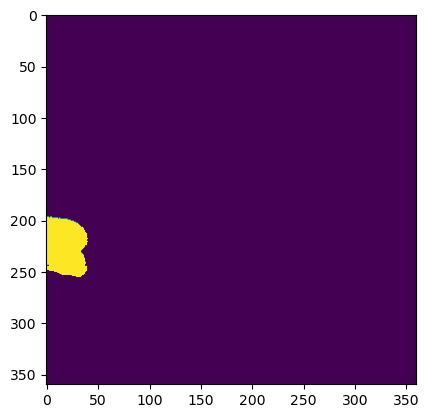

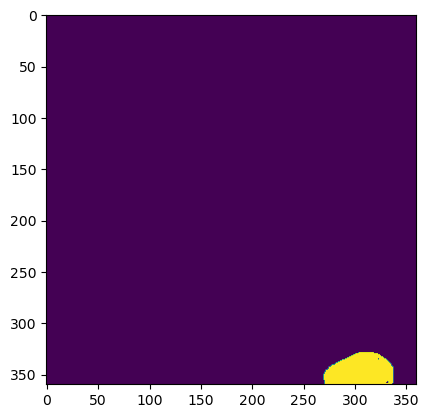

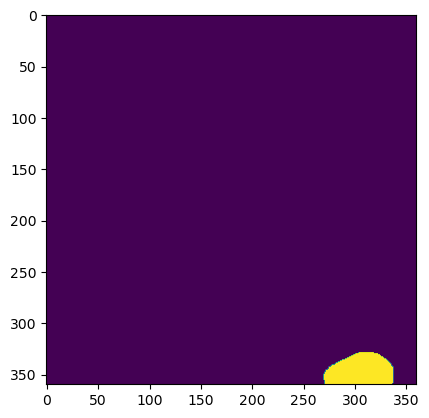

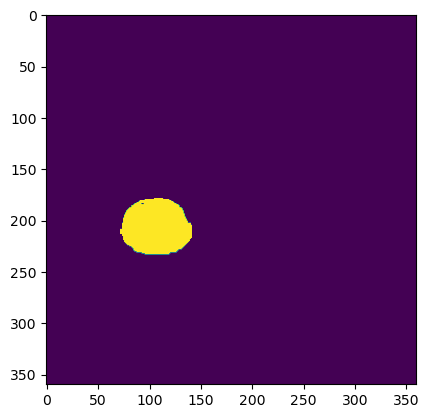

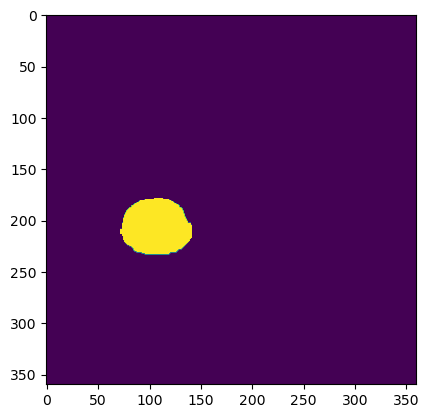

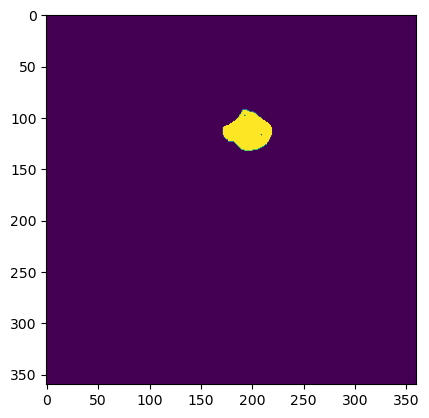

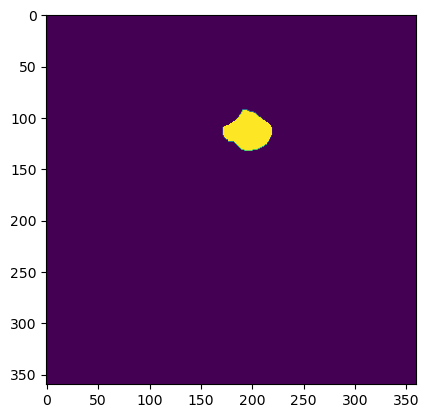

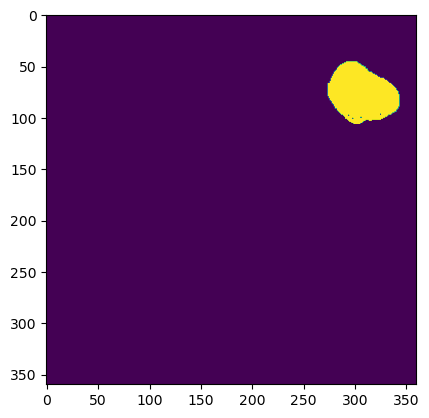

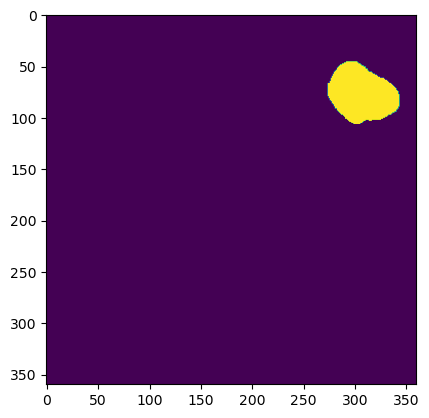

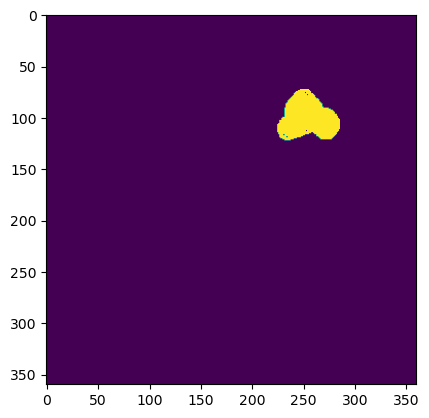

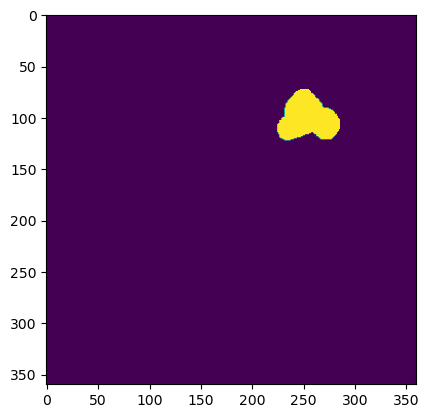

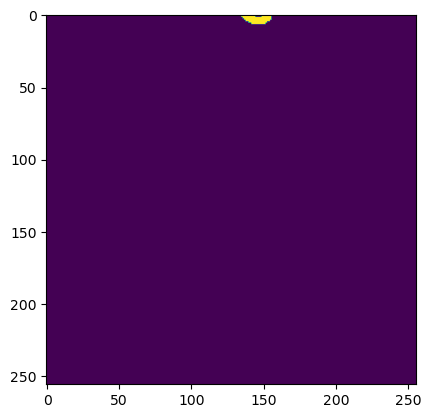

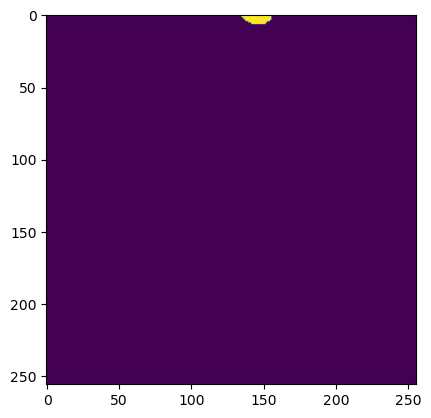

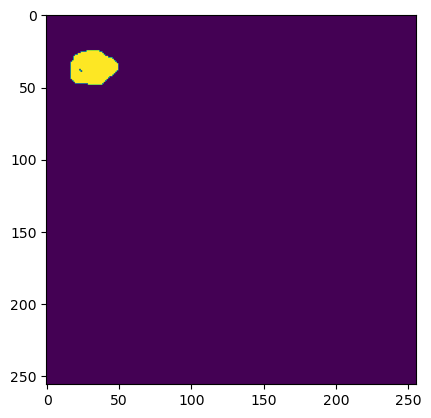

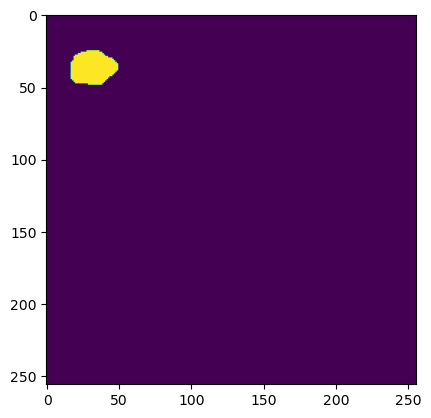

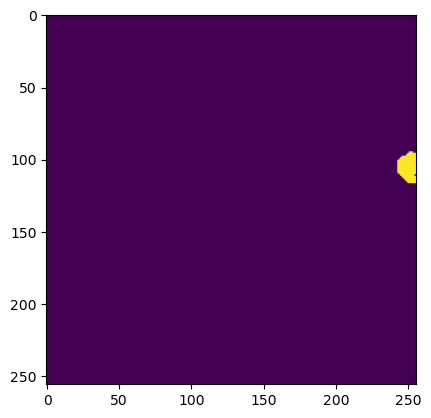

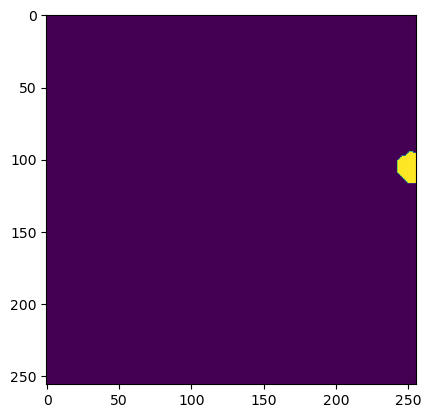

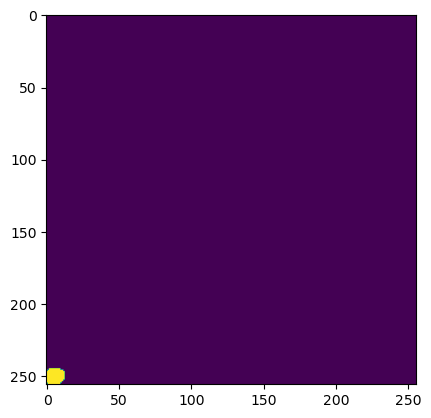

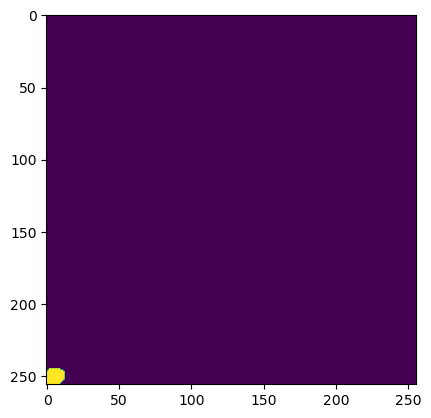

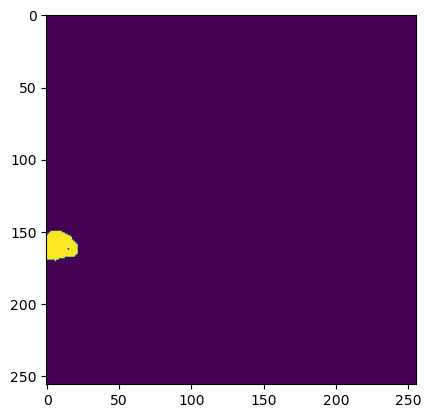

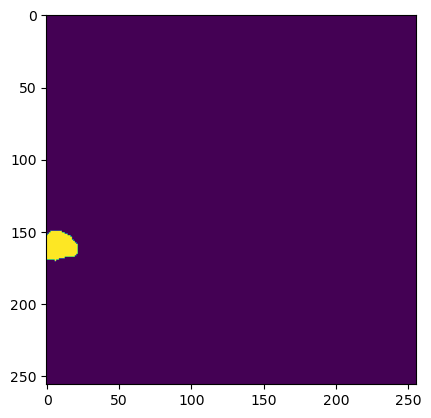

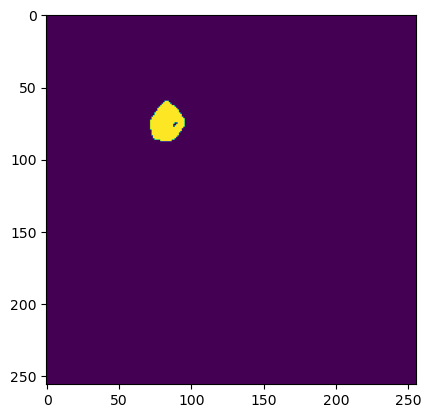

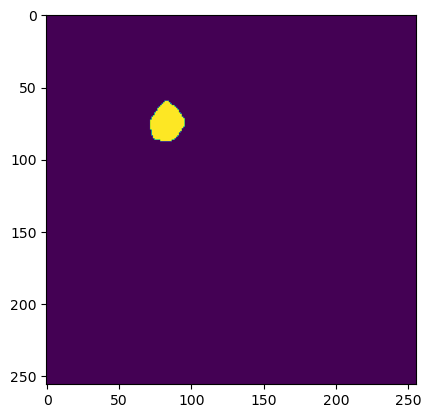

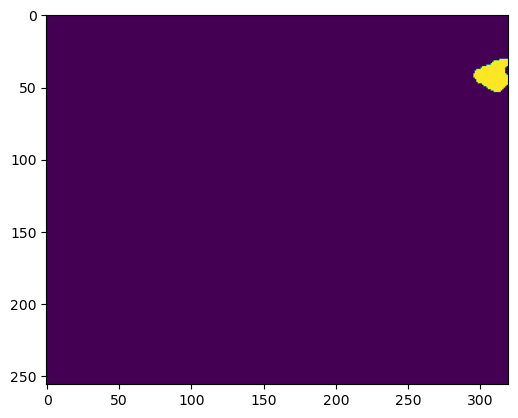

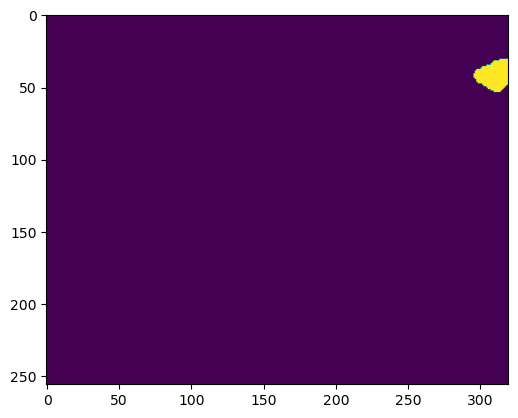

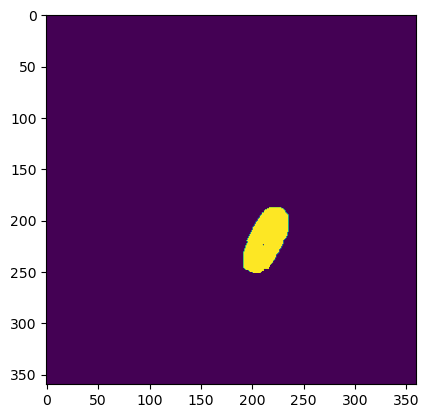

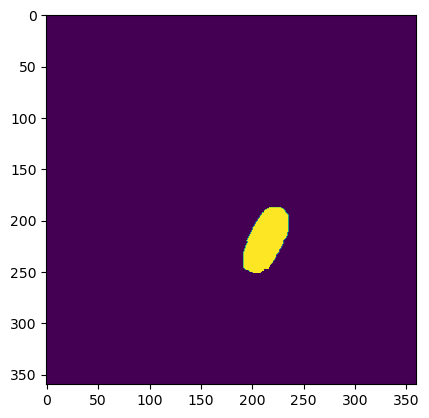

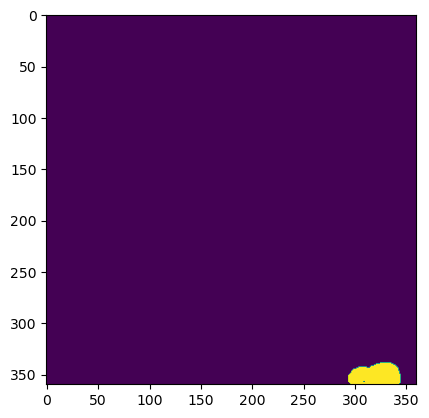

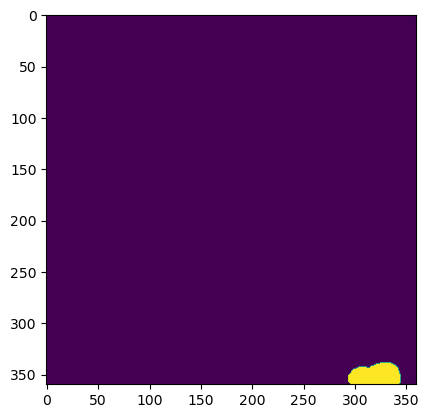

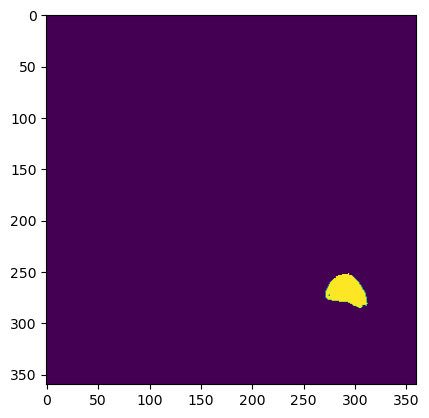

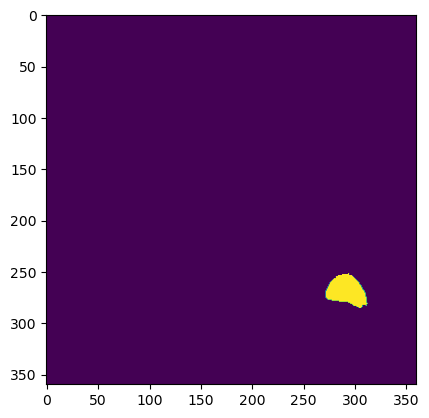

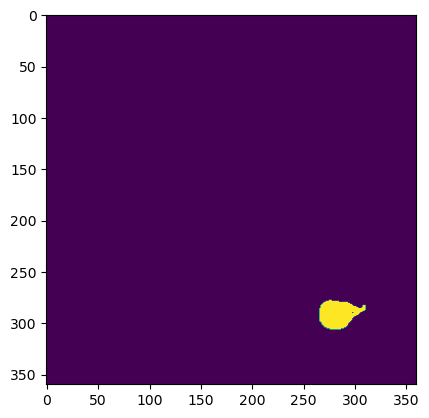

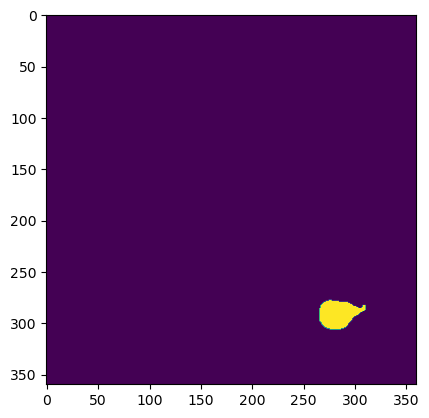

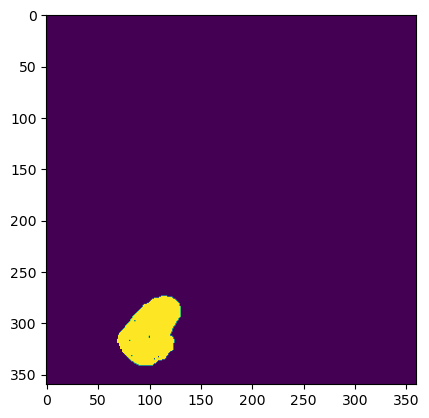

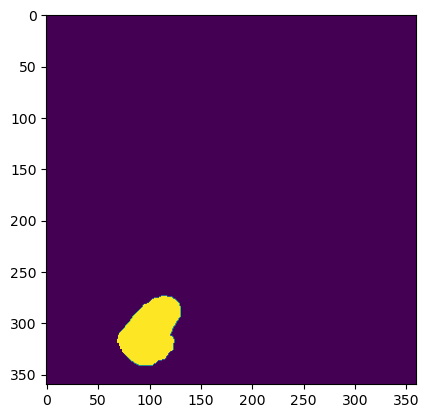

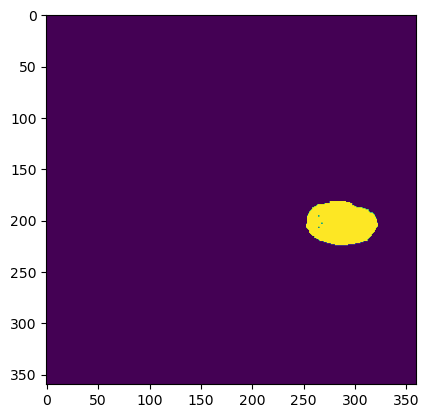

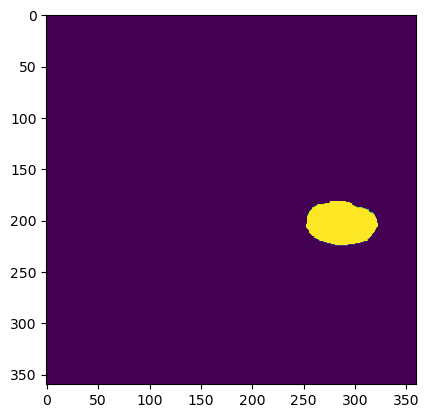

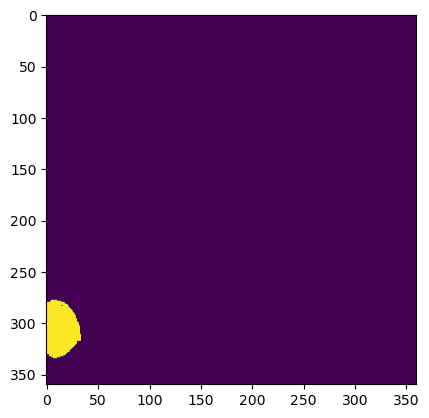

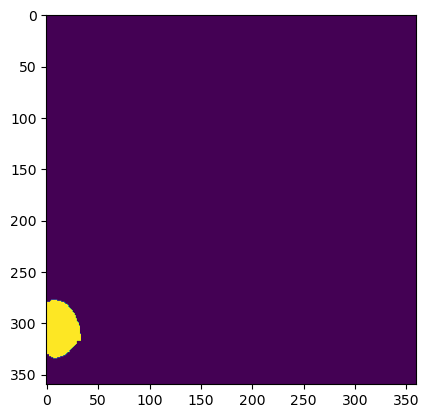

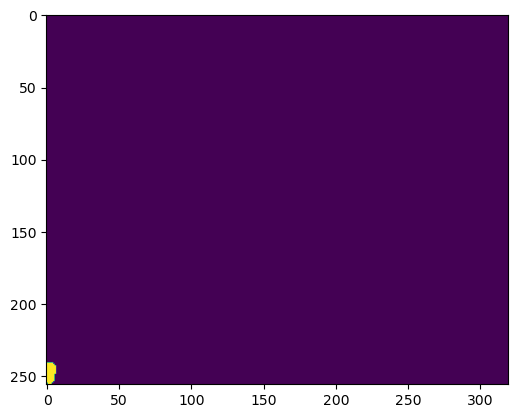

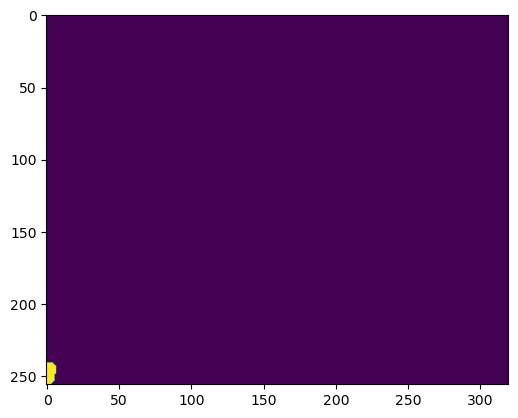

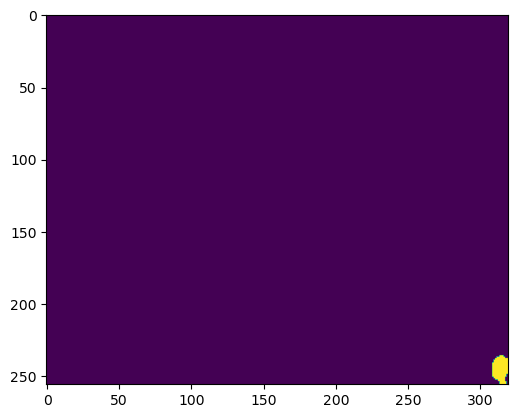

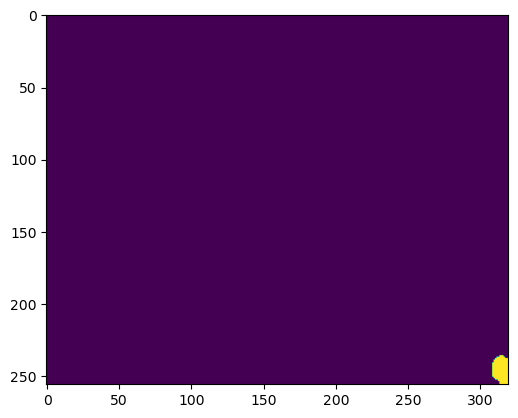

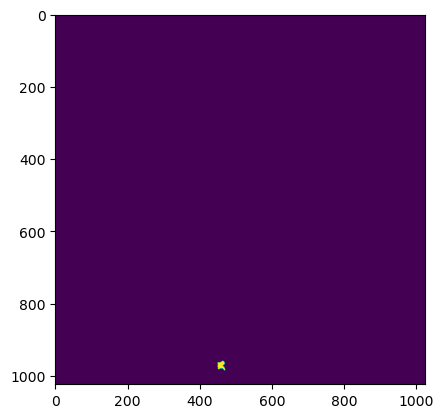

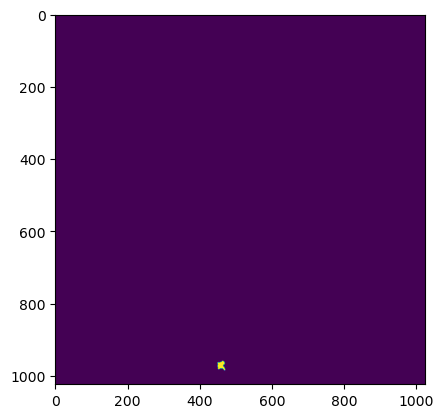

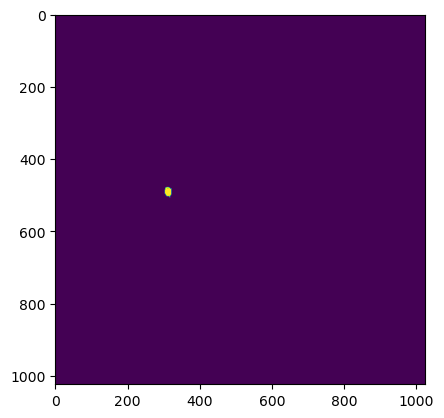

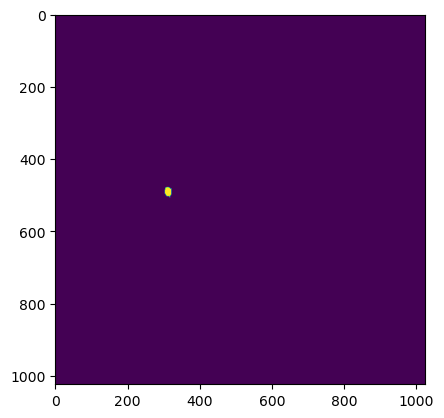

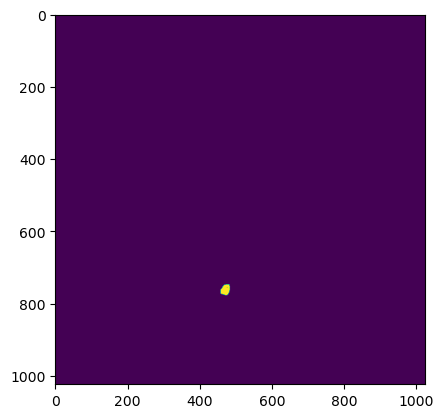

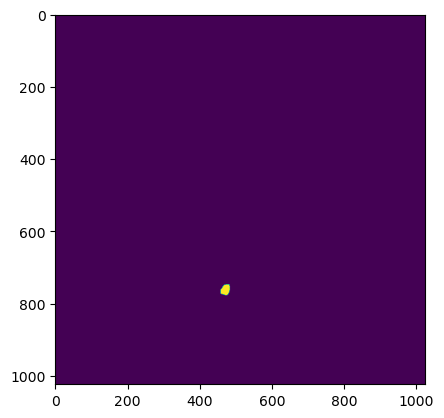

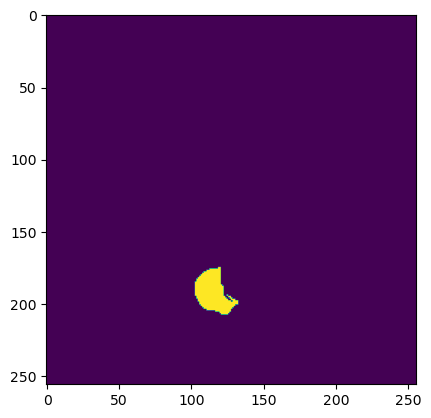

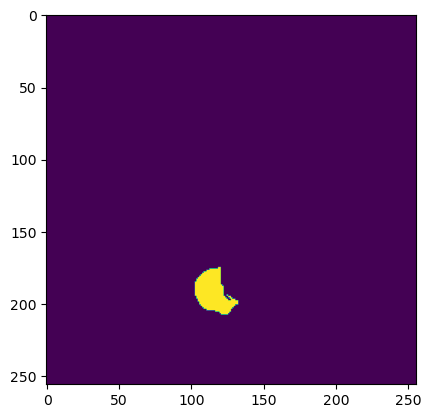

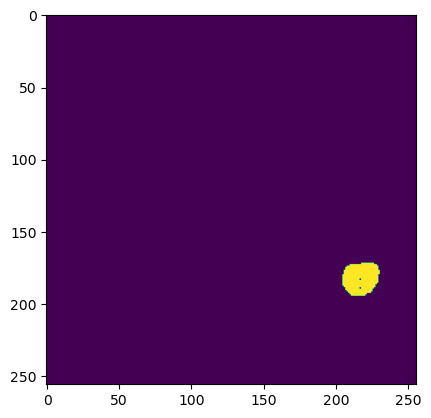

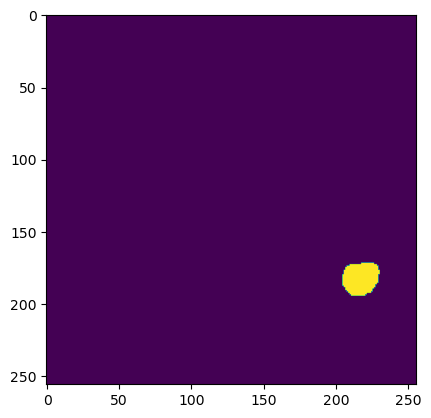

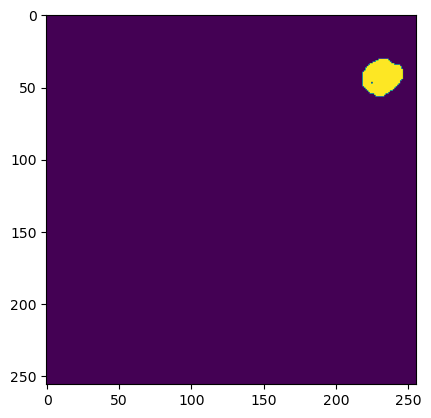

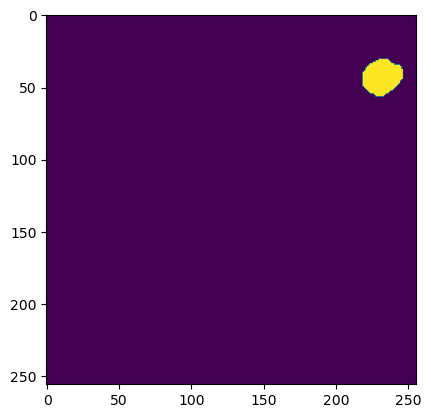

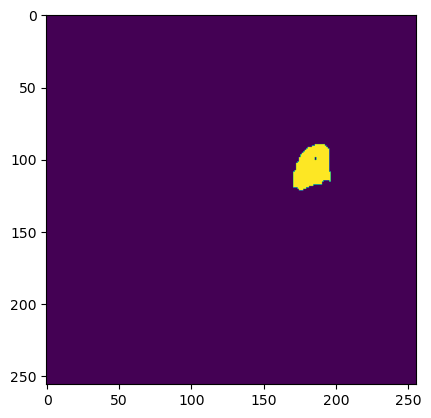

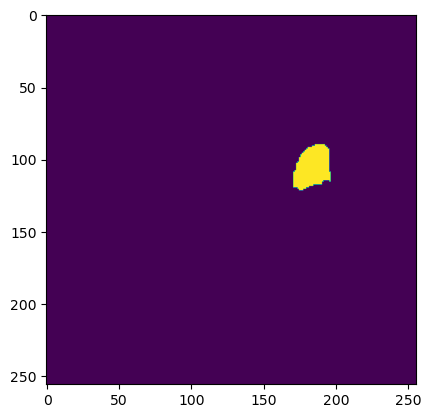

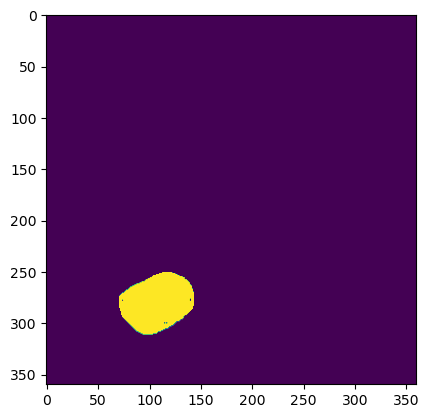

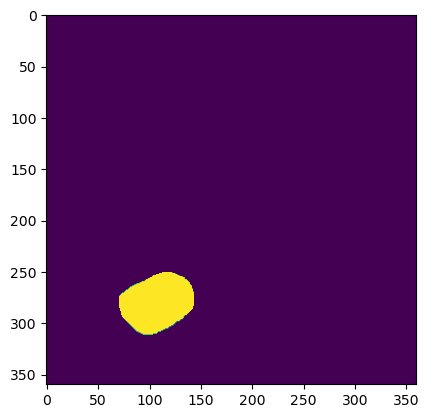

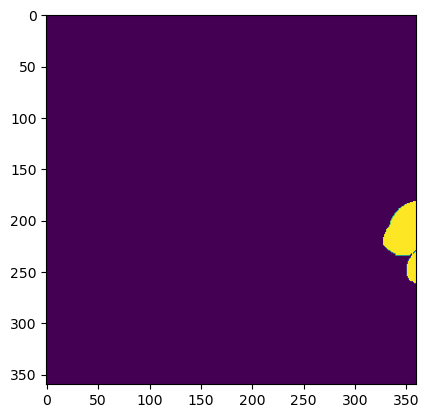

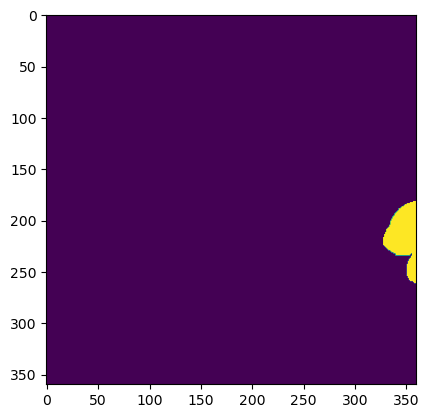

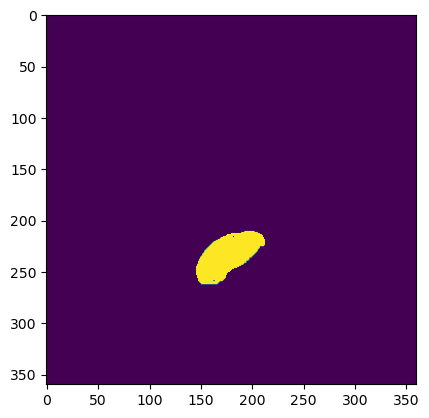

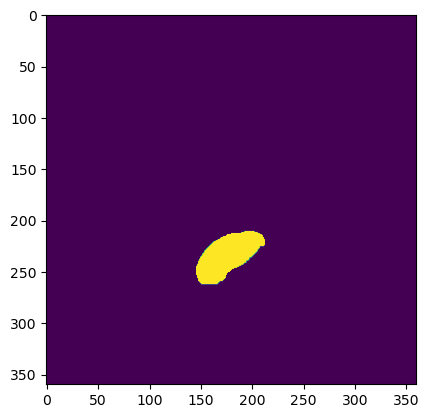

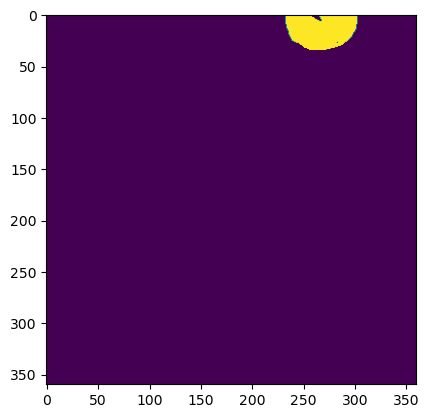

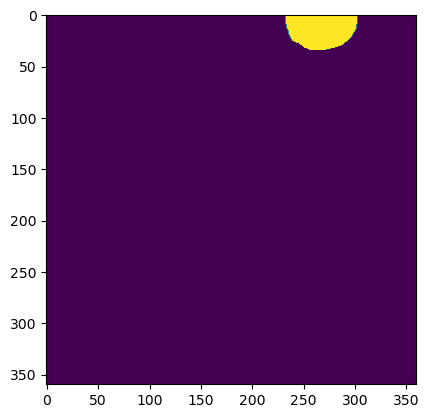

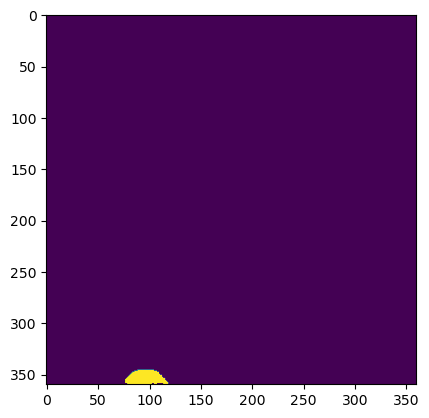

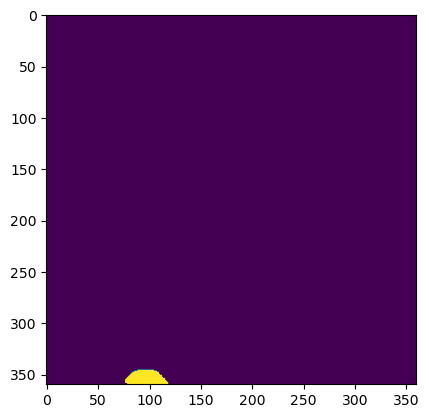

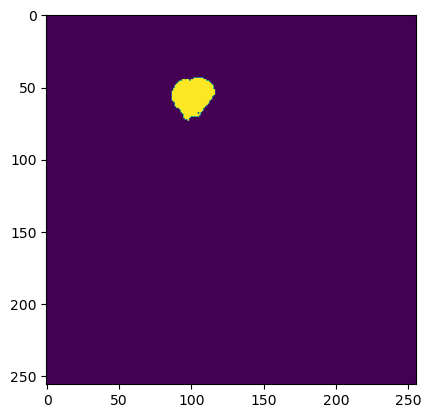

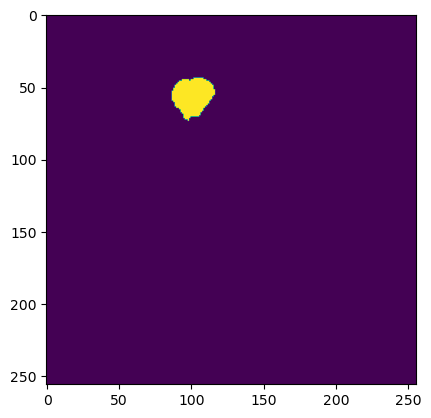

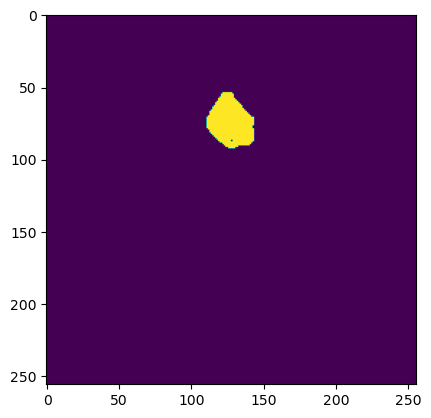

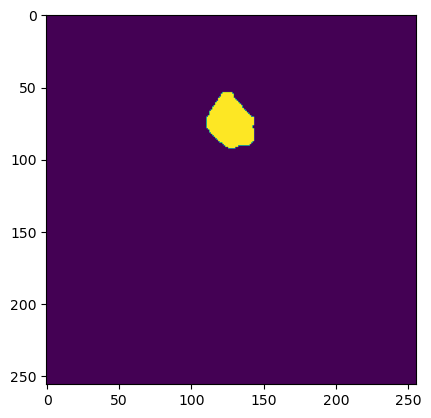

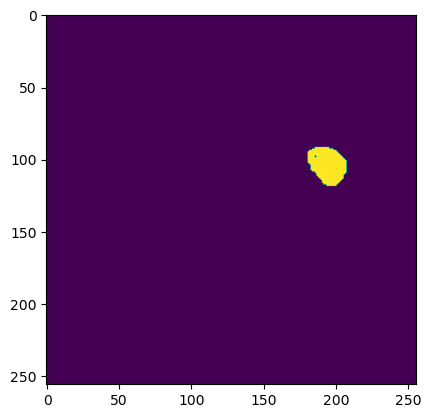

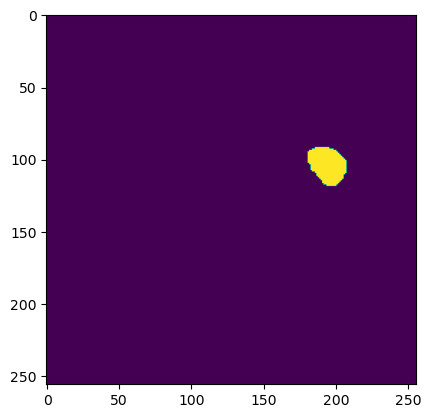

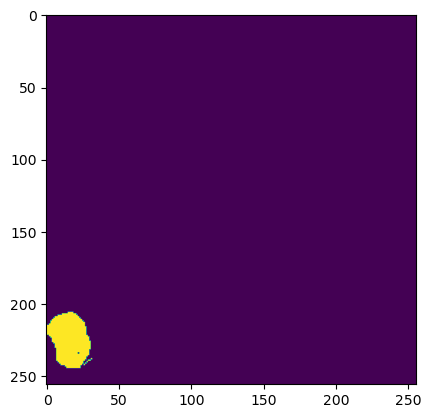

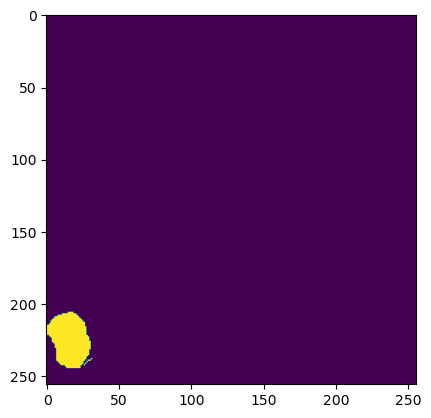

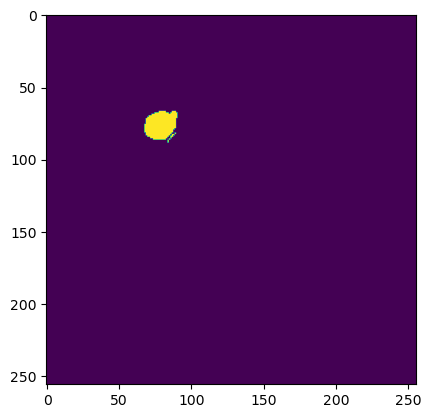

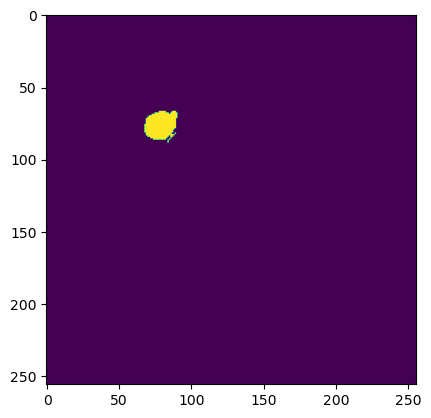

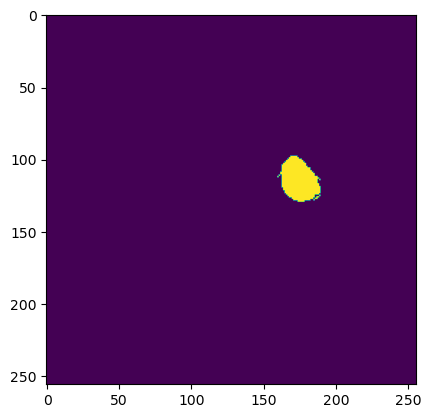

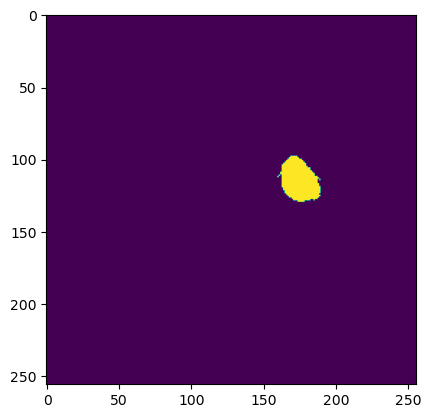

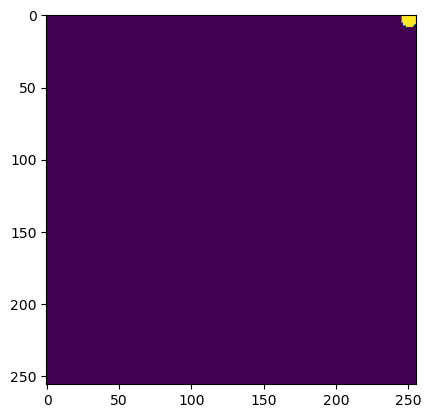

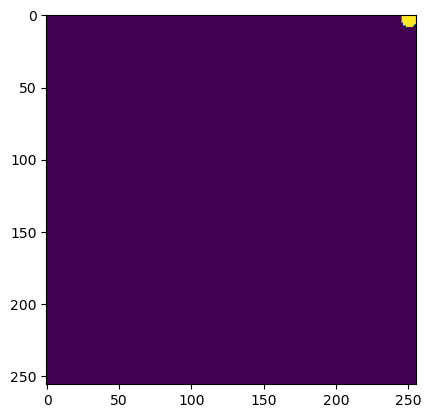

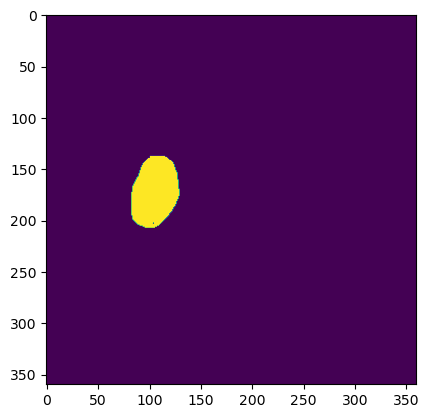

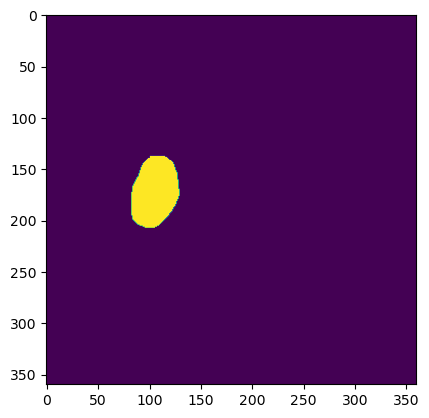

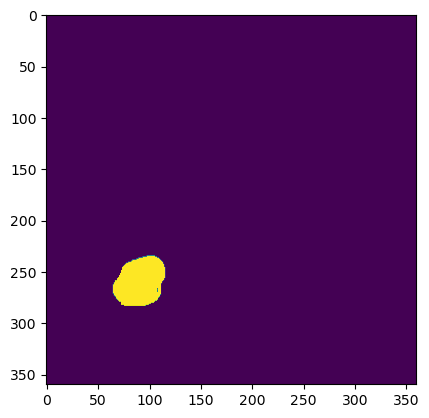

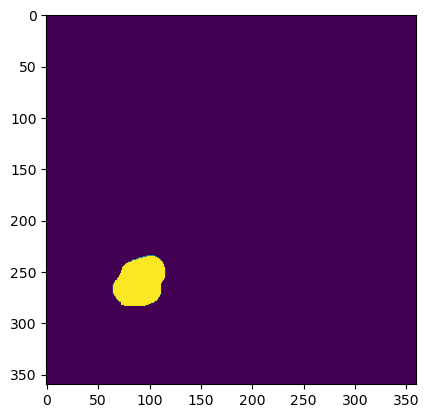

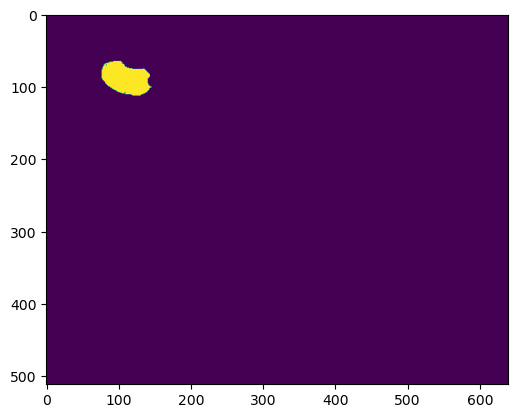

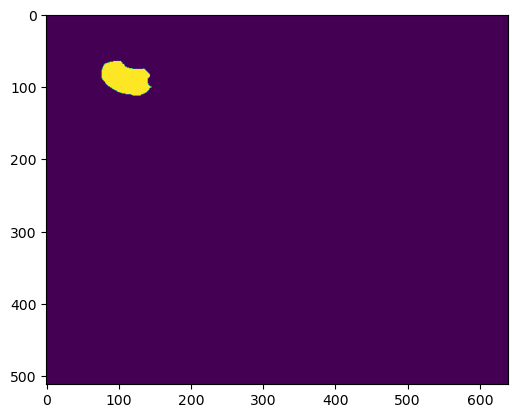

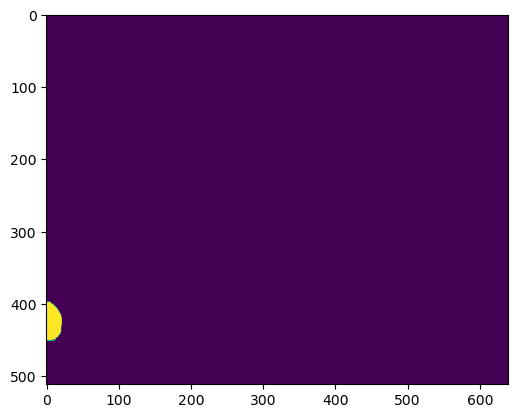

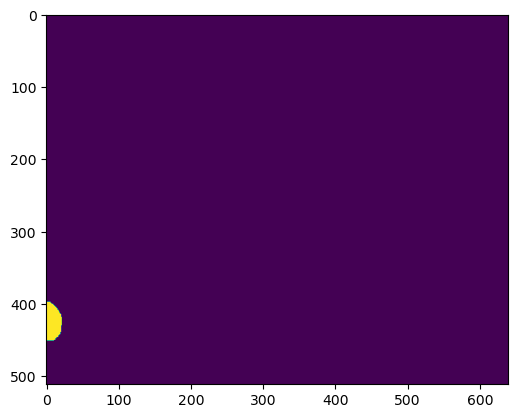

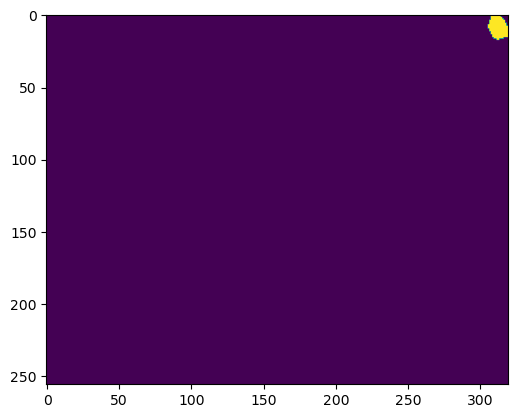

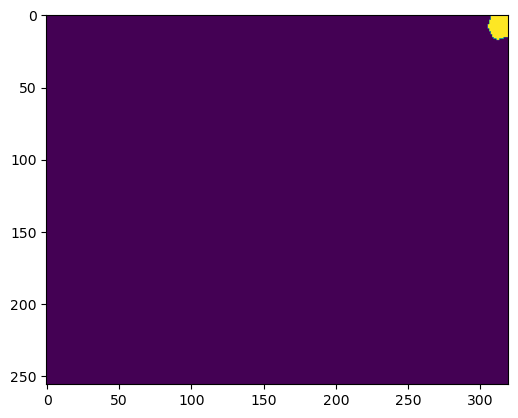

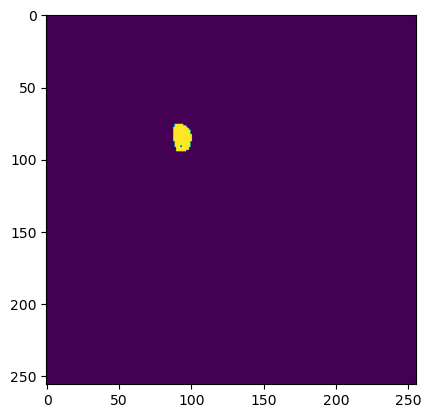

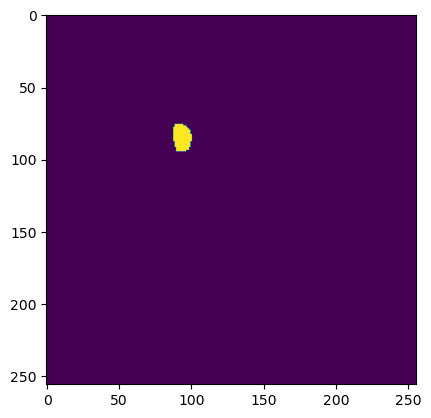

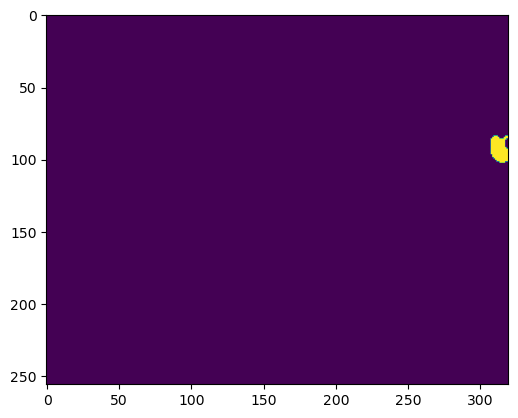

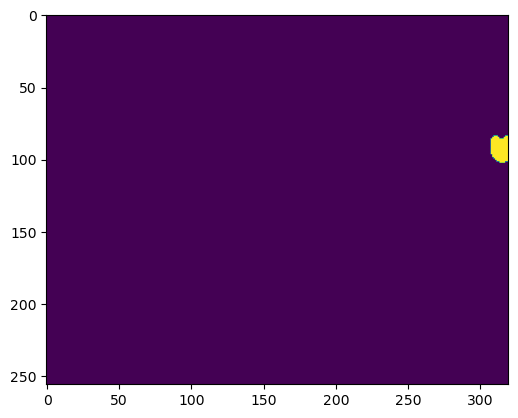

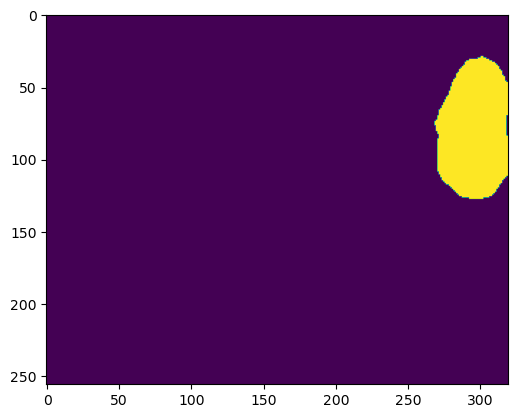

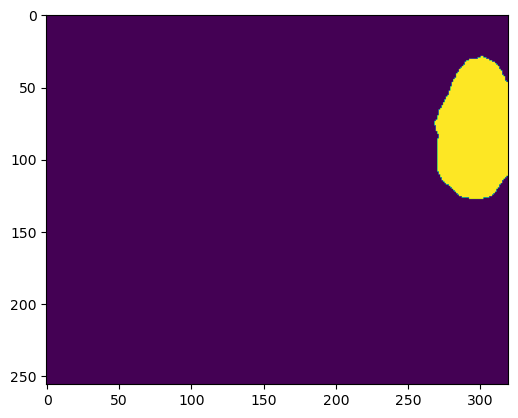

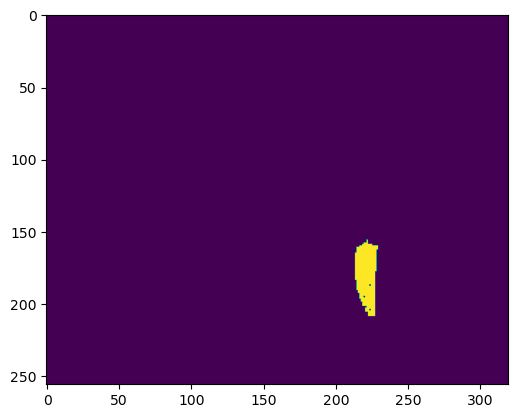

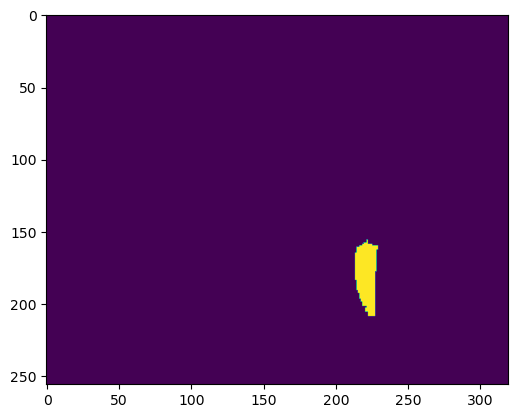

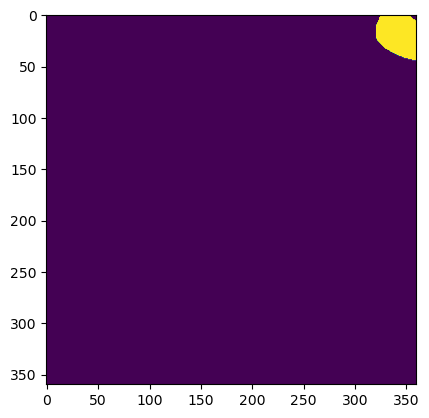

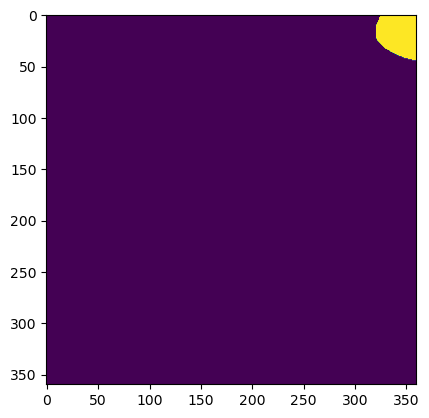

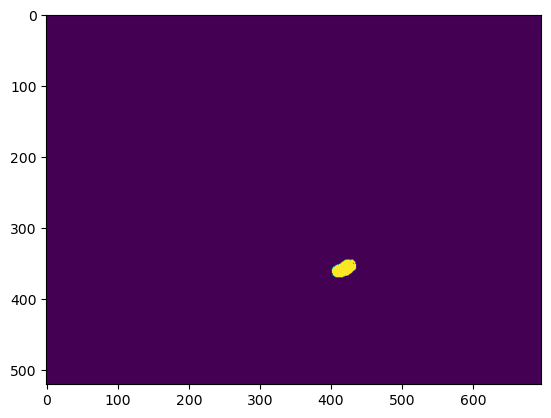

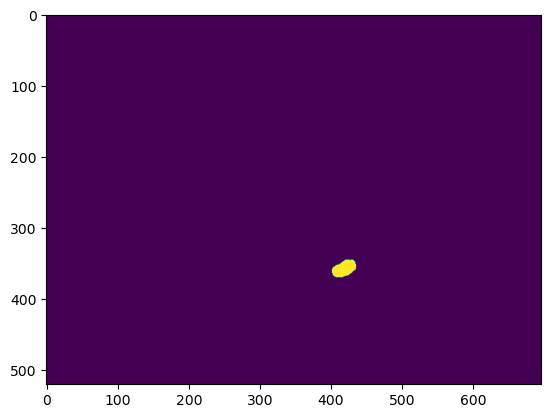

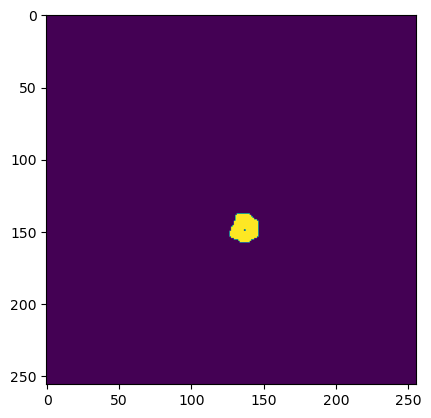

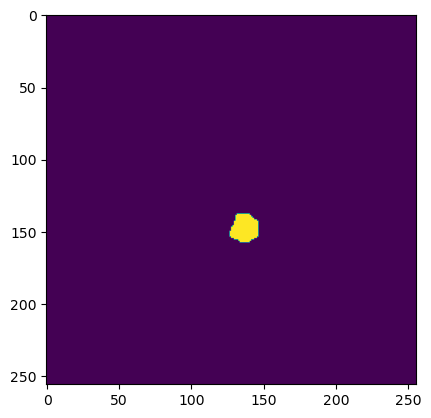

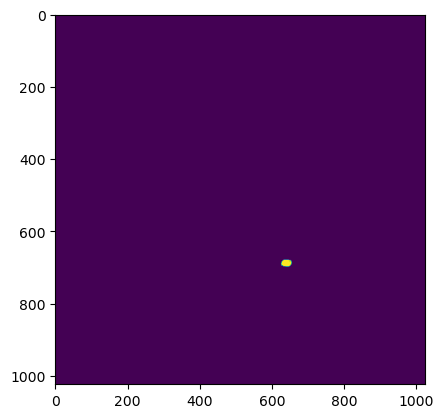

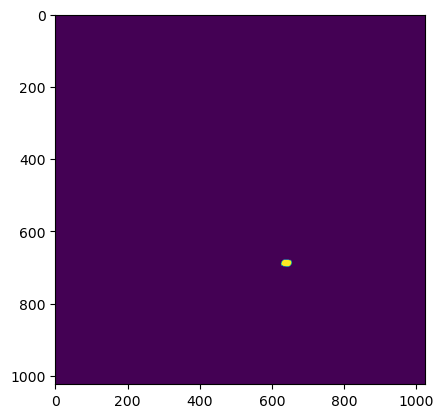

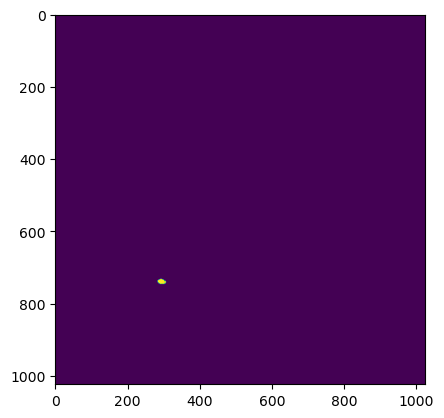

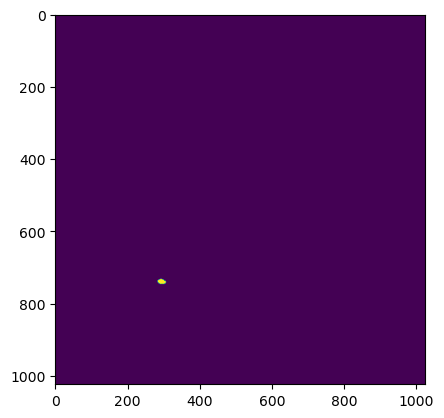

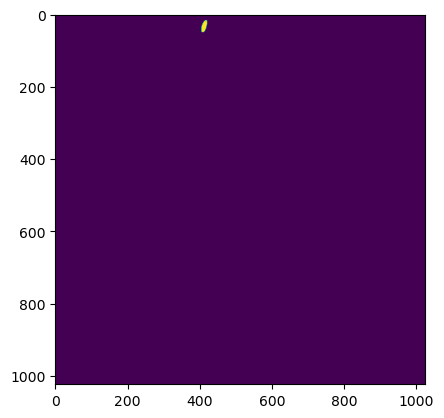

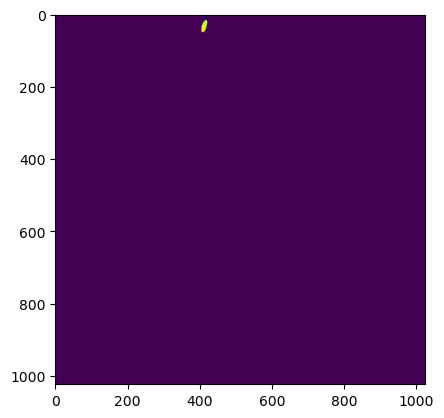

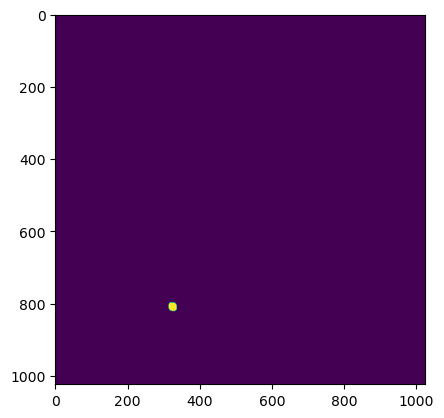

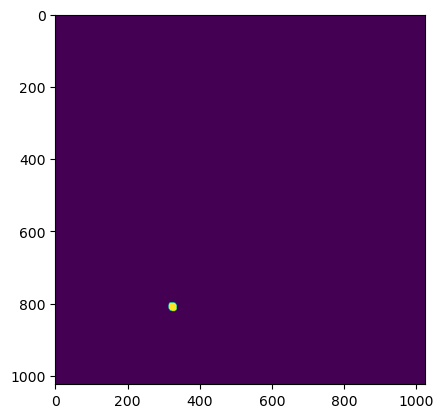

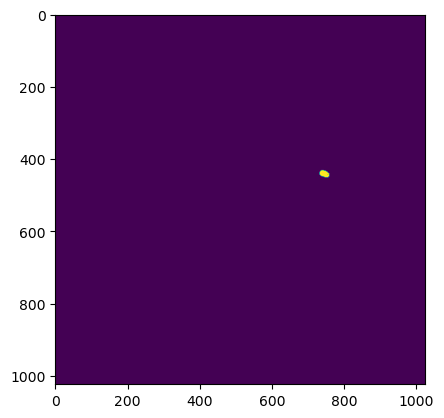

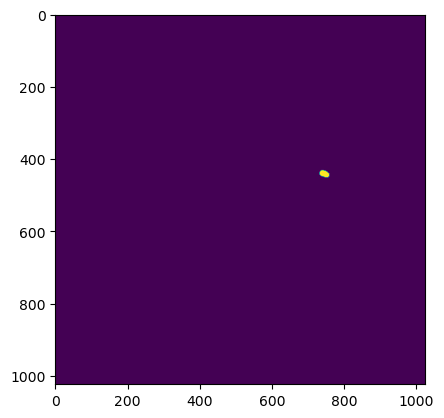

In [8]:
fill_hole_masks("./data/stage1_train")

### Create Combined Masks
The model requires the combined masks for each image as label.

In [7]:
# merge a list of masks (arrays) into one mask
def merge_masks(masks):
    # check dimensions
    dim = masks[0].size
    if not all(map(lambda m: m.size == dim, masks)):
        raise AssertionError("All masks must have the same dimensions")

    msum = np.asarray(Image.new(mode='1', size=dim))
    for m in masks:
        msum = np.ma.mask_or(msum, np.asarray(m))
    im = Image.fromarray(msum)
    
    return im

In [8]:
def create_combined_masks(data_directory):
    for img_dir in os.listdir(data_directory):
        p = f"{data_directory}/{img_dir}/combined_masks"
        if not os.path.exists(p):
            os.mkdir(p)
        merge_masks(list(map(
            lambda m: Image.open(f"{data_directory}/{img_dir}/masks/{m}").convert("1"), 
            os.listdir(f"{data_directory}/{img_dir}/masks")
        ))).save(f"{p}/{img_dir}.png")

create_combined_masks("./data/stage1_test")
create_combined_masks("./data/stage1_train")

## Data Exploration
Now we have all the data we can visualize it

670 Training Images

Image:
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8.png


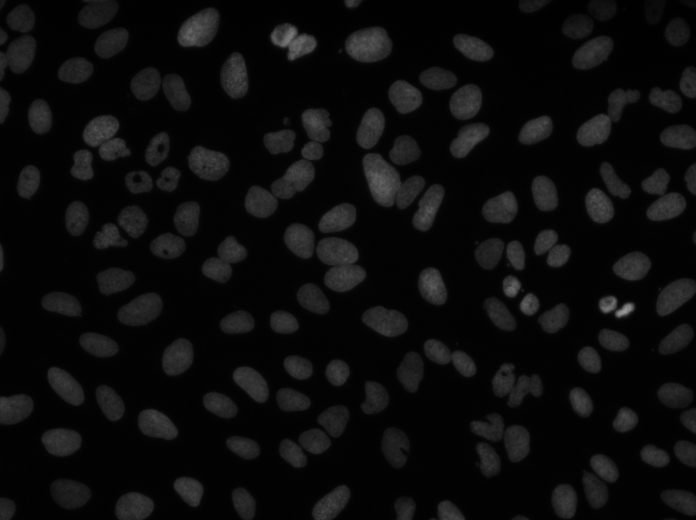

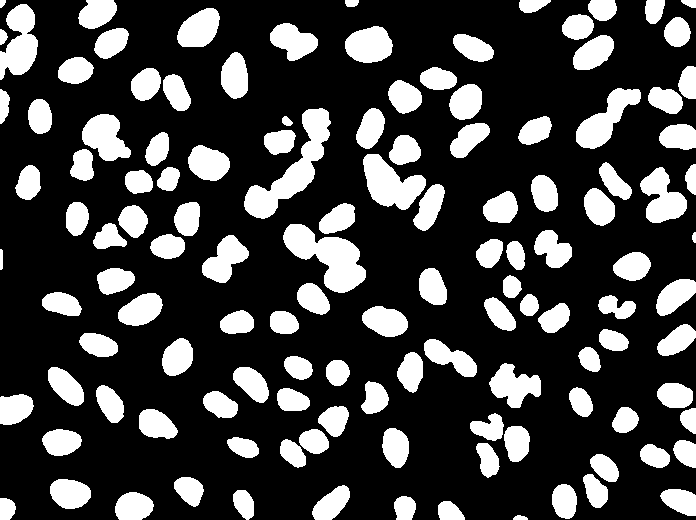

Image:
02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339.png


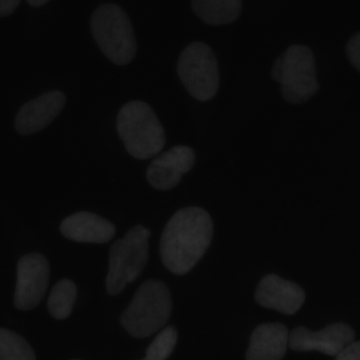

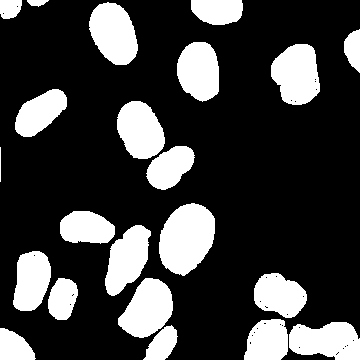

Image:
56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5.png


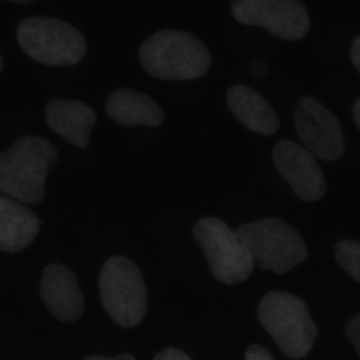

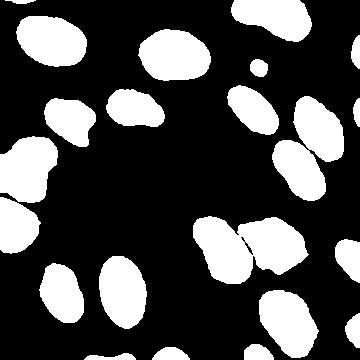

Image:
0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f.png


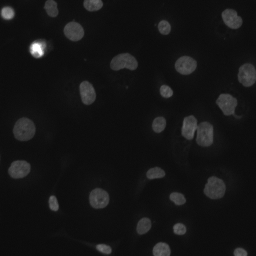

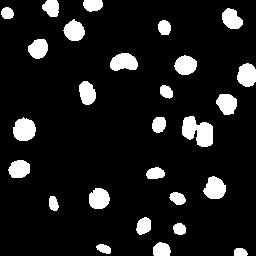

Image:
be26966900aa0e5b41d5a8ecafe04281b37deb05c5cd027968d7b74143398174.png


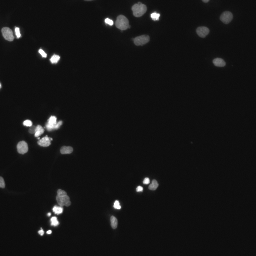

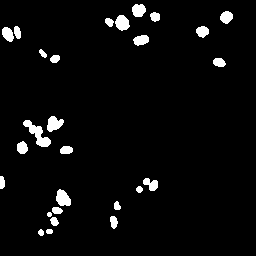

In [9]:
data_dir = "./data/stage1_train"
images_print_amount = 5


tags = os.listdir(data_dir)
print(f"{len(tags)} Training Images")
print()

for i in sample(range(len(tags)), images_print_amount):

    print("Image:")
    path = f"{data_dir}/{tags[i]}/images"
    filename = os.listdir(path)[0]
    print(filename)
    display(DPImage(filename=f"{path}/{filename}"))

    path = f"{data_dir}/{tags[i]}/combined_masks"
    filename = os.listdir(path)[0]
    display(DPImage(filename=f"{path}/{filename}"))

### Data characteristics and distributions

#### 1) Density

Training Data Nucleus Density:


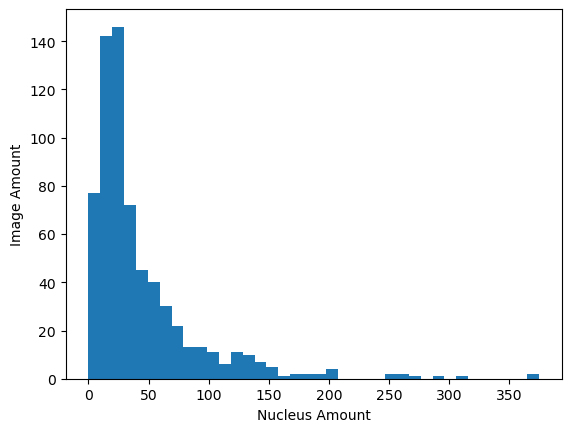

Validation Data Nucleus Density:


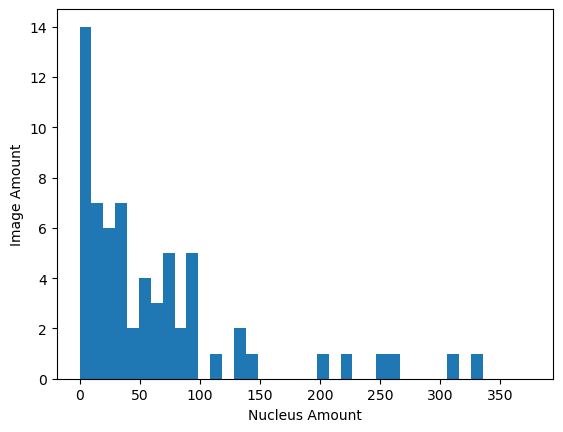

In [10]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"

getDensities = lambda data_dir: [len(os.listdir(f"{data_dir}/{imgId}/masks")) for imgId in os.listdir(data_dir)]
val_dens = getDensities(val_data_dir)
train_dens = getDensities(train_data_dir)

highestDensity = max(val_dens + train_dens)

print("Training Data Nucleus Density:")
plt.hist(train_dens, bins=(highestDensity // 10) + 1, range=(0, highestDensity))
plt.xlabel("Nucleus Amount")
plt.ylabel("Image Amount")
plt.show()

print("Validation Data Nucleus Density:")
plt.hist(val_dens, bins=(highestDensity // 10) + 1, range=(0, highestDensity))
plt.xlabel("Nucleus Amount")
plt.ylabel("Image Amount")
plt.show()


#### 2) Color
Grayscale images have only pixels containing the same brightness in each color channel e.g. (RGB) (100, 100, 100)

In [11]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"

isGrayscale = lambda pixel: pixel[0] == pixel[1] == pixel[2]

areGrayScale = lambda data_dir: [
    all(map(lambda x: isGrayscale(x), 
            Image.open(f"{data_dir}/{imgId}/images/{os.listdir(f'{data_dir}/{imgId}/images')[0]}").getdata()))
    for imgId in os.listdir(data_dir)]

train_gray = areGrayScale(train_data_dir)
val_gray = areGrayScale(val_data_dir)

Training Data grayscale/color distribution:


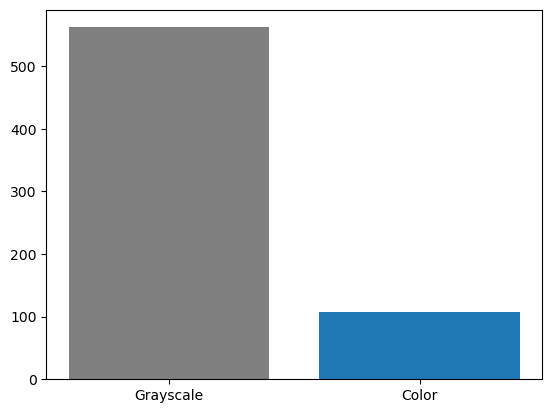

Validation Data grayscale/color distribution:


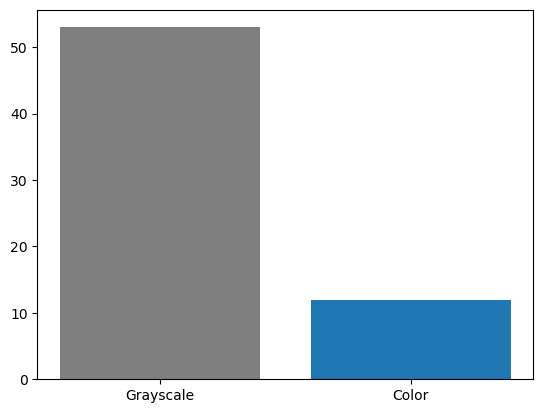

In [12]:
labels = ["Grayscale", "Color"]
colors = ["tab:gray", "tab:blue"]

val_counts = [sum(val_gray), len(val_gray) - sum(val_gray)]
train_counts = [sum(train_gray), len(train_gray) - sum(train_gray)]

print("Training Data grayscale/color distribution:")
plt.bar(labels, train_counts, color=colors)
plt.show()

print("Validation Data grayscale/color distribution:")
plt.bar(labels, val_counts, color=colors)
plt.show()

#### 3) Brightness
Some Images have a higher brightness than others (can be fixed with pre-processing).
(Brightness is calculated by taking the highest value in any color channel)

Training Data Brightness:


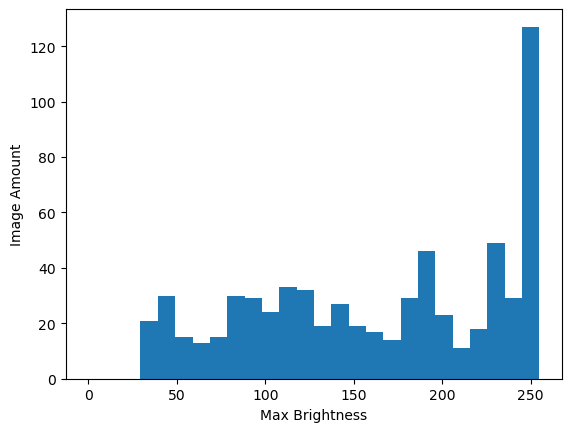

Validation Data Brightness:


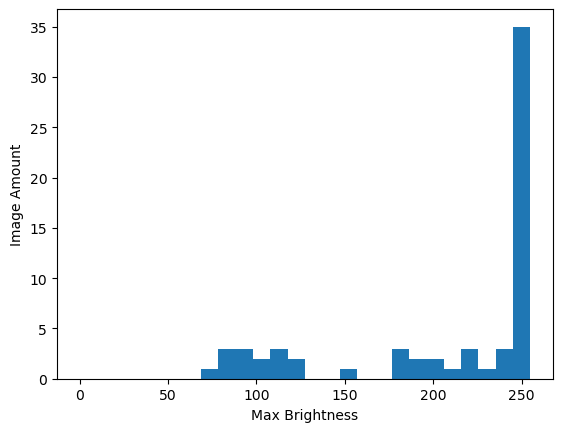

In [13]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"

maxPixelValue = lambda pixels: max(map(lambda x: max(x[:2]), pixels))

maxPixelValues = lambda data_dir: [maxPixelValue(Image.open(f"{data_dir}/{imgId}/images/{os.listdir(f'{data_dir}/{imgId}/images')[0]}").getdata()) for imgId in os.listdir(data_dir)]

train_brightness = maxPixelValues(train_data_dir)
val_brightness = maxPixelValues(val_data_dir)

print("Training Data Brightness:")
plt.hist(train_brightness, bins=(255 // 10) + 1, range=(0, 255))
plt.xlabel("Max Brightness")
plt.ylabel("Image Amount")
plt.show()

print("Validation Data Brightness:")
plt.hist(val_brightness, bins=(255 // 10) + 1, range=(0, 255))
plt.xlabel("Max Brightness")
plt.ylabel("Image Amount")
plt.show()

#### 4) Image dimensions
Images and marks have different dimension. It is given in pixels in the format width x height. (need to be fixed with pre-processing).

The maximum width of imagines of all sets is 1388, and maximum height is 1040.
The minimum width of imagines of all sets is 161, and minimum height is 205.
Training Data Width:


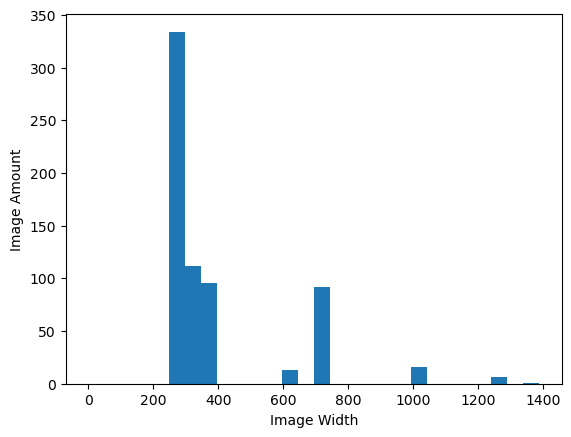

Validation Data Width:


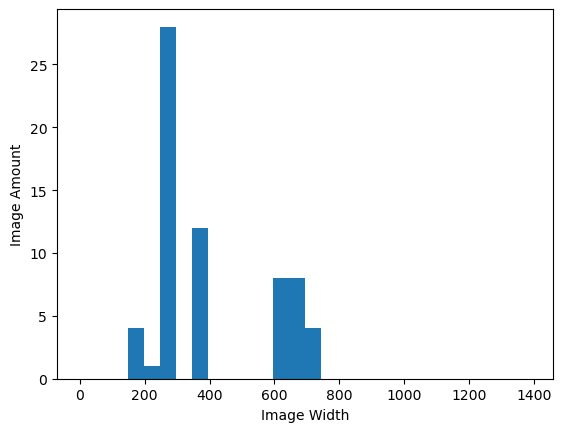

Test Data Width:


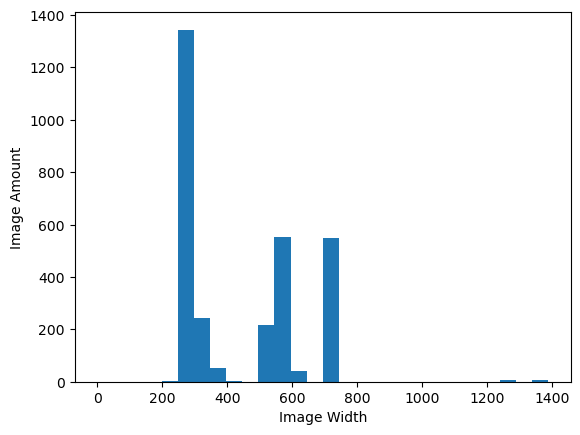

Training Data Height:


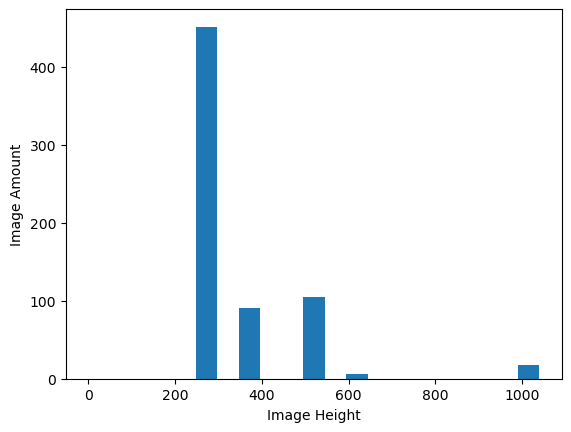

Validation Data Height:


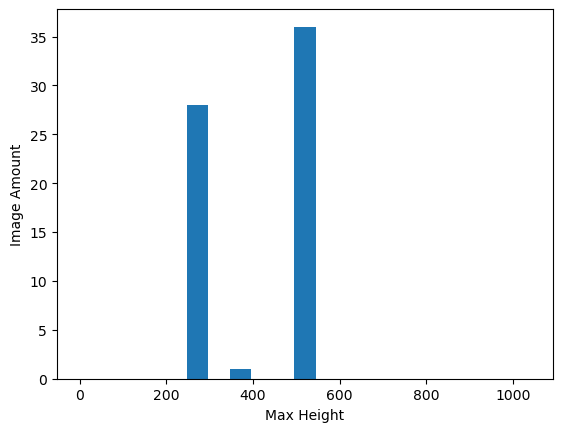

Test Data Height:


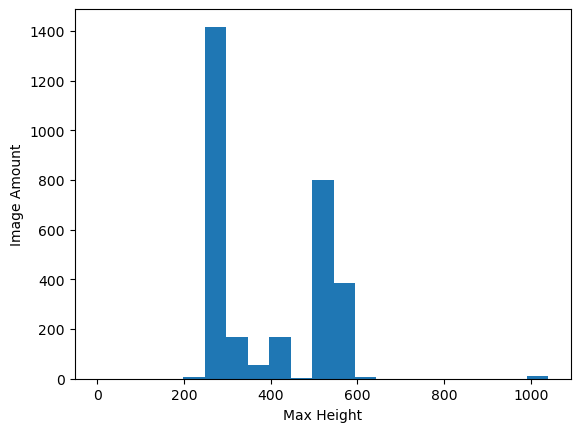

In [14]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"
test_data_dir = "./data/stage2_test_final"

Imag_Sizes = lambda data_dir: [Image.open(f"{data_dir}/{imgId}/images/{os.listdir(f'{data_dir}/{imgId}/images')[0]}").size for imgId in os.listdir(data_dir)]

train_width = [size[0] for size in Imag_Sizes(train_data_dir)]
val_width = [size[0] for size in Imag_Sizes(val_data_dir)]
test_width = [size[0] for size in Imag_Sizes(test_data_dir)]

max_width = max(train_width + val_width + test_width)
min_width = min(train_width + val_width + test_width)

train_height = [size[1] for size in Imag_Sizes(train_data_dir)]
val_height = [size[1] for size in Imag_Sizes(val_data_dir)]
test_height = [size[1] for size in Imag_Sizes(test_data_dir)]

max_height = max(train_height + val_height + test_height)
min_height = min(train_height + val_height + test_height)
print(f"The maximum width of imagines of all sets is {max_width}, and maximum height is {max_height}.")
print(f"The minimum width of imagines of all sets is {min_width}, and minimum height is {min_height}.")

print("Training Data Width:")
plt.hist(train_width, bins=(max_width // 50) + 1, range=(0, max_width))
plt.xlabel("Image Width")
plt.ylabel("Image Amount")
plt.show()

print("Validation Data Width:")
plt.hist(val_width, bins=(max_width // 50) + 1, range=(0, max_width))
plt.xlabel("Image Width")
plt.ylabel("Image Amount")
plt.show()

print("Test Data Width:")
plt.hist(test_width, bins=(max_width // 50) + 1, range=(0, max_width))
plt.xlabel("Image Width")
plt.ylabel("Image Amount")
plt.show()

print("Training Data Height:")
plt.hist(train_height, bins=(max_height // 50) + 1, range=(0, max_height))
plt.xlabel("Image Height")
plt.ylabel("Image Amount")
plt.show()

print("Validation Data Height:")
plt.hist(val_height, bins=(max_height // 50) + 1, range=(0, max_height))
plt.xlabel("Max Height")
plt.ylabel("Image Amount")
plt.show()

print("Test Data Height:")
plt.hist(test_height, bins=(max_height // 50) + 1, range=(0, max_height))
plt.xlabel("Max Height")
plt.ylabel("Image Amount")
plt.show()